# 5. IMC isotope detection limits
## Summary
This notebook calculates limits of detection for different isotopes as measured by imaging mass cytometry.

In [1]:
import pathlib
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import copy

from matplotlib.colors import LogNorm, Normalize
from shutil import copyfile
from imctools.io.mcd.mcdparser import McdParser

import sys
sys.path.insert(0, '..\\code\\')
import high_plex_hdf

Set input and output directories

In [2]:
# Set data directory to work from 
base_dir = "C:/Users/MerrickS/OneDrive/Work/2_UZH/Papers/1_MEZ_XRF"
base_dir = pathlib.Path(base_dir)

# Specify the input directory where hdf files to process are located
input_dir = base_dir / 'data' / 'raw' / 'imc' / 'gelatin_standard_scans'

# Gather filepaths for preprocessed hdfs and config files for XRF fitting
imc_filepaths = list(input_dir.glob('*/*.mcd'))

# Make output directory for unpacked IMC files
out_dir = base_dir / 'data' / 'analysis' / 'imc' / '5_IMC_detection_limits'
out_dir.mkdir(parents=True, exist_ok=True)
print('Detection limits will be output to: \n\t', out_dir) 

# Import periodic table csv
df_periodic_table = pd.read_csv(base_dir / 'data' / 'raw' / 'xrf' / 'Periodic Table of Elements.csv')

Detection limits will be output to: 
	 C:\Users\MerrickS\OneDrive\Work\2_UZH\Papers\1_MEZ_XRF\data\analysis\imc\5_imc_detection_limits


In [3]:
columns = [
    'mcd_filepath',   
    'acq_id',
    'acq_id_description',
    'step_um',
    'x_dim', 
    'y_dim',
    'channel_name',
    'channel_mass',
    'img_mean',
    'img_std',
]

df_standard_measurements = pd.DataFrame(columns=columns)
roi_dict = dict.fromkeys(columns)

for imc_filepath in imc_filepaths:
    roi_dict['mcd_filepath'] = imc_filepath

    with McdParser(imc_filepath) as parser:
        # Get original metadata in XML format
        xml = parser.get_mcd_xml()

        # Get parsed session metadata (i.e. session -> slides -> acquisitions -> channels, panoramas data)
        session = parser.session

        # Get all acquisition IDs
        ids = parser.session.acquisition_ids

        for roi in ids:
            # Get acquisition data for acquisition 
            acq_data = parser.get_acquisition_data(roi)
            
            roi_dict['acq_id'] = roi
            roi_dict['acq_id_description'] = acq_data.acquisition.description
            
            # Check x and y step size consisten before storing
            assert (
                acq_data.acquisition.ablation_distance_between_shots_x 
                == acq_data.acquisition.ablation_distance_between_shots_y
            )
            roi_dict['step_um'] = acq_data.acquisition.ablation_distance_between_shots_x            
            roi_dict['x_dim'] = acq_data.acquisition.max_x
            roi_dict['y_dim'] = acq_data.acquisition.max_y
            
            for counter, channel in enumerate(acq_data.acquisition.channel_names):
                roi_dict['channel_name'] = channel
                roi_dict['channel_mass'] = acq_data.acquisition.channel_masses[counter]
                
                # 20x20 measurement for xrf measure roi size consistency
                img = acq_data.get_image_by_name(channel)[:20, :20] 
                roi_dict['img_mean'] = img.mean()
                roi_dict['img_std'] = img.std()
                
                df_standard_measurements = df_standard_measurements.append(
                    roi_dict,
                    ignore_index=True
                )
                

In [4]:
# Extract sample name and contents (element name if element, ppm concentration if mix)
df_standard_measurements['sample_name'] = (
    df_standard_measurements.acq_id_description.str.split(
        '_', expand=True).iloc[:,0]
)

df_standard_measurements['contents'] = (
    df_standard_measurements.acq_id_description.str.split(
        '_', expand=True).iloc[:,1]
)      

In [5]:
df_standard_measurements['contents_tidy'] = df_standard_measurements['contents'].str.replace('pt', '.').copy()
df_standard_measurements['contents_tidy'] = df_standard_measurements['contents_tidy'].str.replace('blank', '0')


In [6]:
# Add float concentration column to dilution series samples
df_standard_measurements['concentration_ppm'] = (
    pd.to_numeric(df_standard_measurements['contents_tidy'], errors='coerce')
)

# Add single element description column to single element 200 ppm samples
df_standard_measurements['sample_element'] = (
    df_standard_measurements.contents[
        df_standard_measurements['concentration_ppm'].isna()
    ]
)

In [7]:
df_standard_measurements.columns

Index(['mcd_filepath', 'acq_id', 'acq_id_description', 'step_um', 'x_dim',
       'y_dim', 'channel_name', 'channel_mass', 'img_mean', 'img_std',
       'sample_name', 'contents', 'contents_tidy', 'concentration_ppm',
       'sample_element'],
      dtype='object')

In [8]:
df_standard_measurements['acq_id_description'][
    df_standard_measurements['acq_id_description'].str.contains('blank_')
].unique()

array(['191_blank_1um', '191_blank_2um', '191_blank_0pt5um'], dtype=object)

In [9]:
df_sample_elements = df_standard_measurements[
    (df_standard_measurements['sample_element'].notna()) 
    | (df_standard_measurements['acq_id_description'].str.contains('blank_0pt')
)
].copy()

In [10]:
blanks = ['blank1'] * 70 + ['blank2'] * 70
df_sample_elements.loc[df_sample_elements['acq_id_description'].str.contains('blank_0pt'), 'sample_element'] = blanks

In [11]:
df_sample_elements.loc[df_sample_elements['sample_element'].isna(), 'sample_element'] = 'blank'
df_ele_isotopes = df_sample_elements[['img_mean', 'sample_element', 'channel_mass']][df_sample_elements['step_um'] == 0.5]

In [12]:
df_ele_isotopes

,img_mean,sample_element,channel_mass
1890,4326.305176,Gd,80
1891,0.442897,Gd,87
1892,0.367360,Gd,88
1893,0.241802,Gd,89
1894,0.227138,Gd,90
...,...,...,...
4685,0.010000,blank2,191
4686,0.021221,blank2,192
4687,0.010796,blank2,193
4688,0.023367,blank2,194


In [13]:
df_ele_isotopes = df_ele_isotopes.pivot_table(
    index='channel_mass', 
    columns='sample_element', 
    values='img_mean',
    #aggfunc='mean' # averages the repat blank measurements
)

In [14]:
df_ele_isotopes

sample_element,Ag,Ce,Dy,Er,Eu,Gd,Ho,In,Ir,La,Lu,Nd,Pr,Sm,Tb,Tm,Y,Yb,blank1,blank2
channel_mass,,,,,,,,,,,,,,,,,,,,
105,0.040986,0.043220,0.032709,0.047924,0.025000,0.025241,0.027500,0.027500,0.032500,0.036120,0.036636,0.030000,0.026345,0.043347,0.040000,0.042500,0.051338,0.042500,0.044241,0.032778
106,0.037754,0.020158,0.022500,0.025000,0.016238,0.035319,0.027500,0.040094,0.030000,0.047471,0.025000,0.029591,0.032500,0.022500,0.027500,0.017806,0.045494,0.034295,0.045000,0.025000
107,25.129448,0.047500,0.015978,0.037631,0.020000,0.023065,0.015000,0.029246,0.033297,0.015000,0.027469,0.020000,0.010000,0.030197,0.050109,0.017500,0.007500,0.024553,0.026184,0.012500
108,0.099539,0.020065,0.013503,0.025000,0.012553,0.015000,0.005000,0.012500,0.010770,0.015000,0.015000,0.022836,0.028986,0.007500,0.012500,0.030110,0.035596,0.010000,0.034480,0.020000
109,25.112076,0.028574,0.010872,0.004502,0.023211,0.029974,0.020000,0.013723,0.025000,0.038914,0.020495,0.011181,0.015000,0.007712,0.021877,0.013961,0.018601,0.026753,0.021504,0.020000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,0.365923,0.495427,0.447836,0.455265,0.448961,0.442897,0.470248,0.509584,0.442703,0.460818,0.454006,0.455389,0.456028,0.445022,0.456974,0.395116,0.425795,0.455256,0.427256,0.495785
88,0.366976,0.362836,0.354289,0.281568,0.327020,0.367360,0.302716,0.331150,0.320219,0.300997,0.282283,0.295407,0.294910,0.308567,0.306630,0.307956,0.370706,0.311845,0.314453,0.274897
89,0.219474,0.277497,0.219537,0.348384,0.212833,0.241802,0.226480,0.218386,0.229225,0.300883,0.211044,0.227099,0.264180,0.235995,0.240152,0.207792,72.662804,0.295016,0.230739,0.217920


In [15]:
atomic_numbers = []
for element in df_ele_isotopes.columns:
    if 'blank' in element:
        print(element)
        atomic_numbers.append(0)
    else:
        ele_z = df_periodic_table.loc[
            df_periodic_table['Symbol'] == element, 'AtomicNumber'
        ].iloc[0]
        print(element, ele_z)
        atomic_numbers.append(ele_z)

df_element_sort = pd.DataFrame()
df_element_sort['AtomicNumber'] = atomic_numbers
df_element_sort['element'] = df_ele_isotopes.columns

# Sort columns to atomic number order
ordered_elements = list(df_element_sort.sort_values('AtomicNumber')['element'])
df_ele_isotopes = df_ele_isotopes[ordered_elements]

# Sort rows to isotope order
df_ele_isotopes.index = df_ele_isotopes.index.astype(int)
df_ele_isotopes = df_ele_isotopes.sort_index()


Ag 47
Ce 58
Dy 66
Er 68
Eu 63
Gd 64
Ho 67
In 49
Ir 77
La 57
Lu 71
Nd 60
Pr 59
Sm 62
Tb 65
Tm 69
Y 39
Yb 70
blank1
blank2


In [16]:
df_ele_isotopes.columns[~df_ele_isotopes.columns.str.contains('blank')][9:]


Index(['Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Ir'], dtype='object', name='sample_element')

In [17]:
df_ele_isotopes[['Y', 'Ag', 'In', 'La', 'Ce', 'Pr', 'Nd', 'Sm', 'Eu']]

sample_element,Y,Ag,In,La,Ce,Pr,Nd,Sm,Eu
channel_mass,,,,,,,,,
80,4738.500000,4700.398926,4660.292480,4453.349609,4429.012695,4378.095703,4382.491699,4551.100098,4415.834473
87,0.425795,0.365923,0.509584,0.460818,0.495427,0.456028,0.455389,0.445022,0.448961
88,0.370706,0.366976,0.331150,0.300997,0.362836,0.294910,0.295407,0.308567,0.327020
89,72.662804,0.219474,0.218386,0.300883,0.277497,0.264180,0.227099,0.235995,0.212833
90,0.389050,0.243767,0.226590,0.241292,0.226671,0.244872,0.201203,0.300079,0.250438
...,...,...,...,...,...,...,...,...,...
191,0.018588,0.010269,0.010514,0.008296,0.008114,0.017774,0.031126,0.011212,0.011075
192,0.045540,0.044883,0.013280,0.027085,0.036018,0.011689,0.034857,0.027584,0.030675
193,0.013244,0.025607,0.009239,0.018593,0.011950,0.031904,0.012500,0.028612,0.022436


In [18]:
# Deals with 0 backgrounds in blank 1
for blank_zero_iso in df_ele_isotopes['blank1'][df_ele_isotopes['blank1'] == 0].keys():
    neighbours = [blank_zero_iso +1, blank_zero_iso-1]
    neighbour_avg = np.mean(df_ele_isotopes['blank1'][neighbours])
    df_ele_isotopes['blank1'][df_ele_isotopes['blank1'].index == blank_zero_iso] = neighbour_avg
# Deals with 0 backgrounds in blank 2    
for blank_zero_iso in df_ele_isotopes['blank2'][df_ele_isotopes['blank2'] == 0].keys():
    neighbours = [blank_zero_iso +1, blank_zero_iso-1]
    neighbour_avg = np.mean(df_ele_isotopes['blank2'][neighbours])
    df_ele_isotopes['blank2'][df_ele_isotopes['blank2'].index == blank_zero_iso] = neighbour_avg

# Normalises counts by dividing by background
df_blank_div = df_ele_isotopes.loc[:, ~df_ele_isotopes.columns.str.contains('blank')].copy()
ele_set1 = ['Y', 'Ag', 'In', 'La', 'Ce', 'Pr', 'Nd', 'Sm', 'Eu']
ele_set2 = ['Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Ir']
df_blank_div[ele_set1] = df_blank_div[ele_set1].divide(df_ele_isotopes['blank1'], axis=0)
df_blank_div[ele_set2] = df_blank_div[ele_set2].divide(df_ele_isotopes['blank2'], axis=0)

# Get isotope contributions for each element as a percentage
df_ele_iso_contibution = df_blank_div.divide(df_blank_div.sum(axis=0), axis=1)

In [19]:
df_ele_iso_contibution

sample_element,Y,Ag,In,La,Ce,Pr,Nd,Sm,Eu,Gd,Tb,Dy,Ho,Er,Tm,Yb,Lu,Ir
channel_mass,,,,,,,,,,,,,,,,,,
80,0.003068,0.000535,0.000192,0.000328,0.000217,0.000276,0.000119,0.000077,0.000088,0.000035,0.000073,0.000031,0.000014,0.000012,0.000084,0.000038,0.000026,0.000034
87,0.002532,0.000383,0.000193,0.000312,0.000223,0.000264,0.000113,0.000069,0.000082,0.000032,0.000073,0.000030,0.000015,0.000012,0.000072,0.000038,0.000025,0.000033
88,0.002995,0.000521,0.000170,0.000277,0.000222,0.000232,0.000100,0.000065,0.000082,0.000048,0.000089,0.000043,0.000017,0.000013,0.000101,0.000047,0.000028,0.000043
89,0.800147,0.000425,0.000153,0.000377,0.000231,0.000283,0.000105,0.000067,0.000072,0.000040,0.000087,0.000034,0.000016,0.000021,0.000086,0.000056,0.000027,0.000039
90,0.005116,0.000564,0.000190,0.000361,0.000225,0.000314,0.000111,0.000102,0.000102,0.000033,0.000094,0.000033,0.000018,0.000015,0.000089,0.000038,0.000029,0.000044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,0.009446,0.000917,0.000340,0.000480,0.000312,0.000880,0.000663,0.000148,0.000174,0.000060,0.000055,0.000050,0.000024,0.000023,0.000202,0.000107,0.000059,0.371972
192,0.003848,0.000667,0.000071,0.000260,0.000230,0.000096,0.000123,0.000061,0.000080,0.000029,0.000098,0.000067,0.000024,0.000029,0.000121,0.000064,0.000056,0.001429
193,0.002681,0.000911,0.000119,0.000428,0.000183,0.000629,0.000106,0.000150,0.000140,0.000045,0.000037,0.000056,0.000042,0.000044,0.000257,0.000117,0.000078,0.620978


C:\Users\MerrickS\OneDrive\Work\2_UZH\Papers\1_MEZ_XRF\data\analysis\imc\5_imc_detection_limits\ExtF3a_IMCmetals.svg


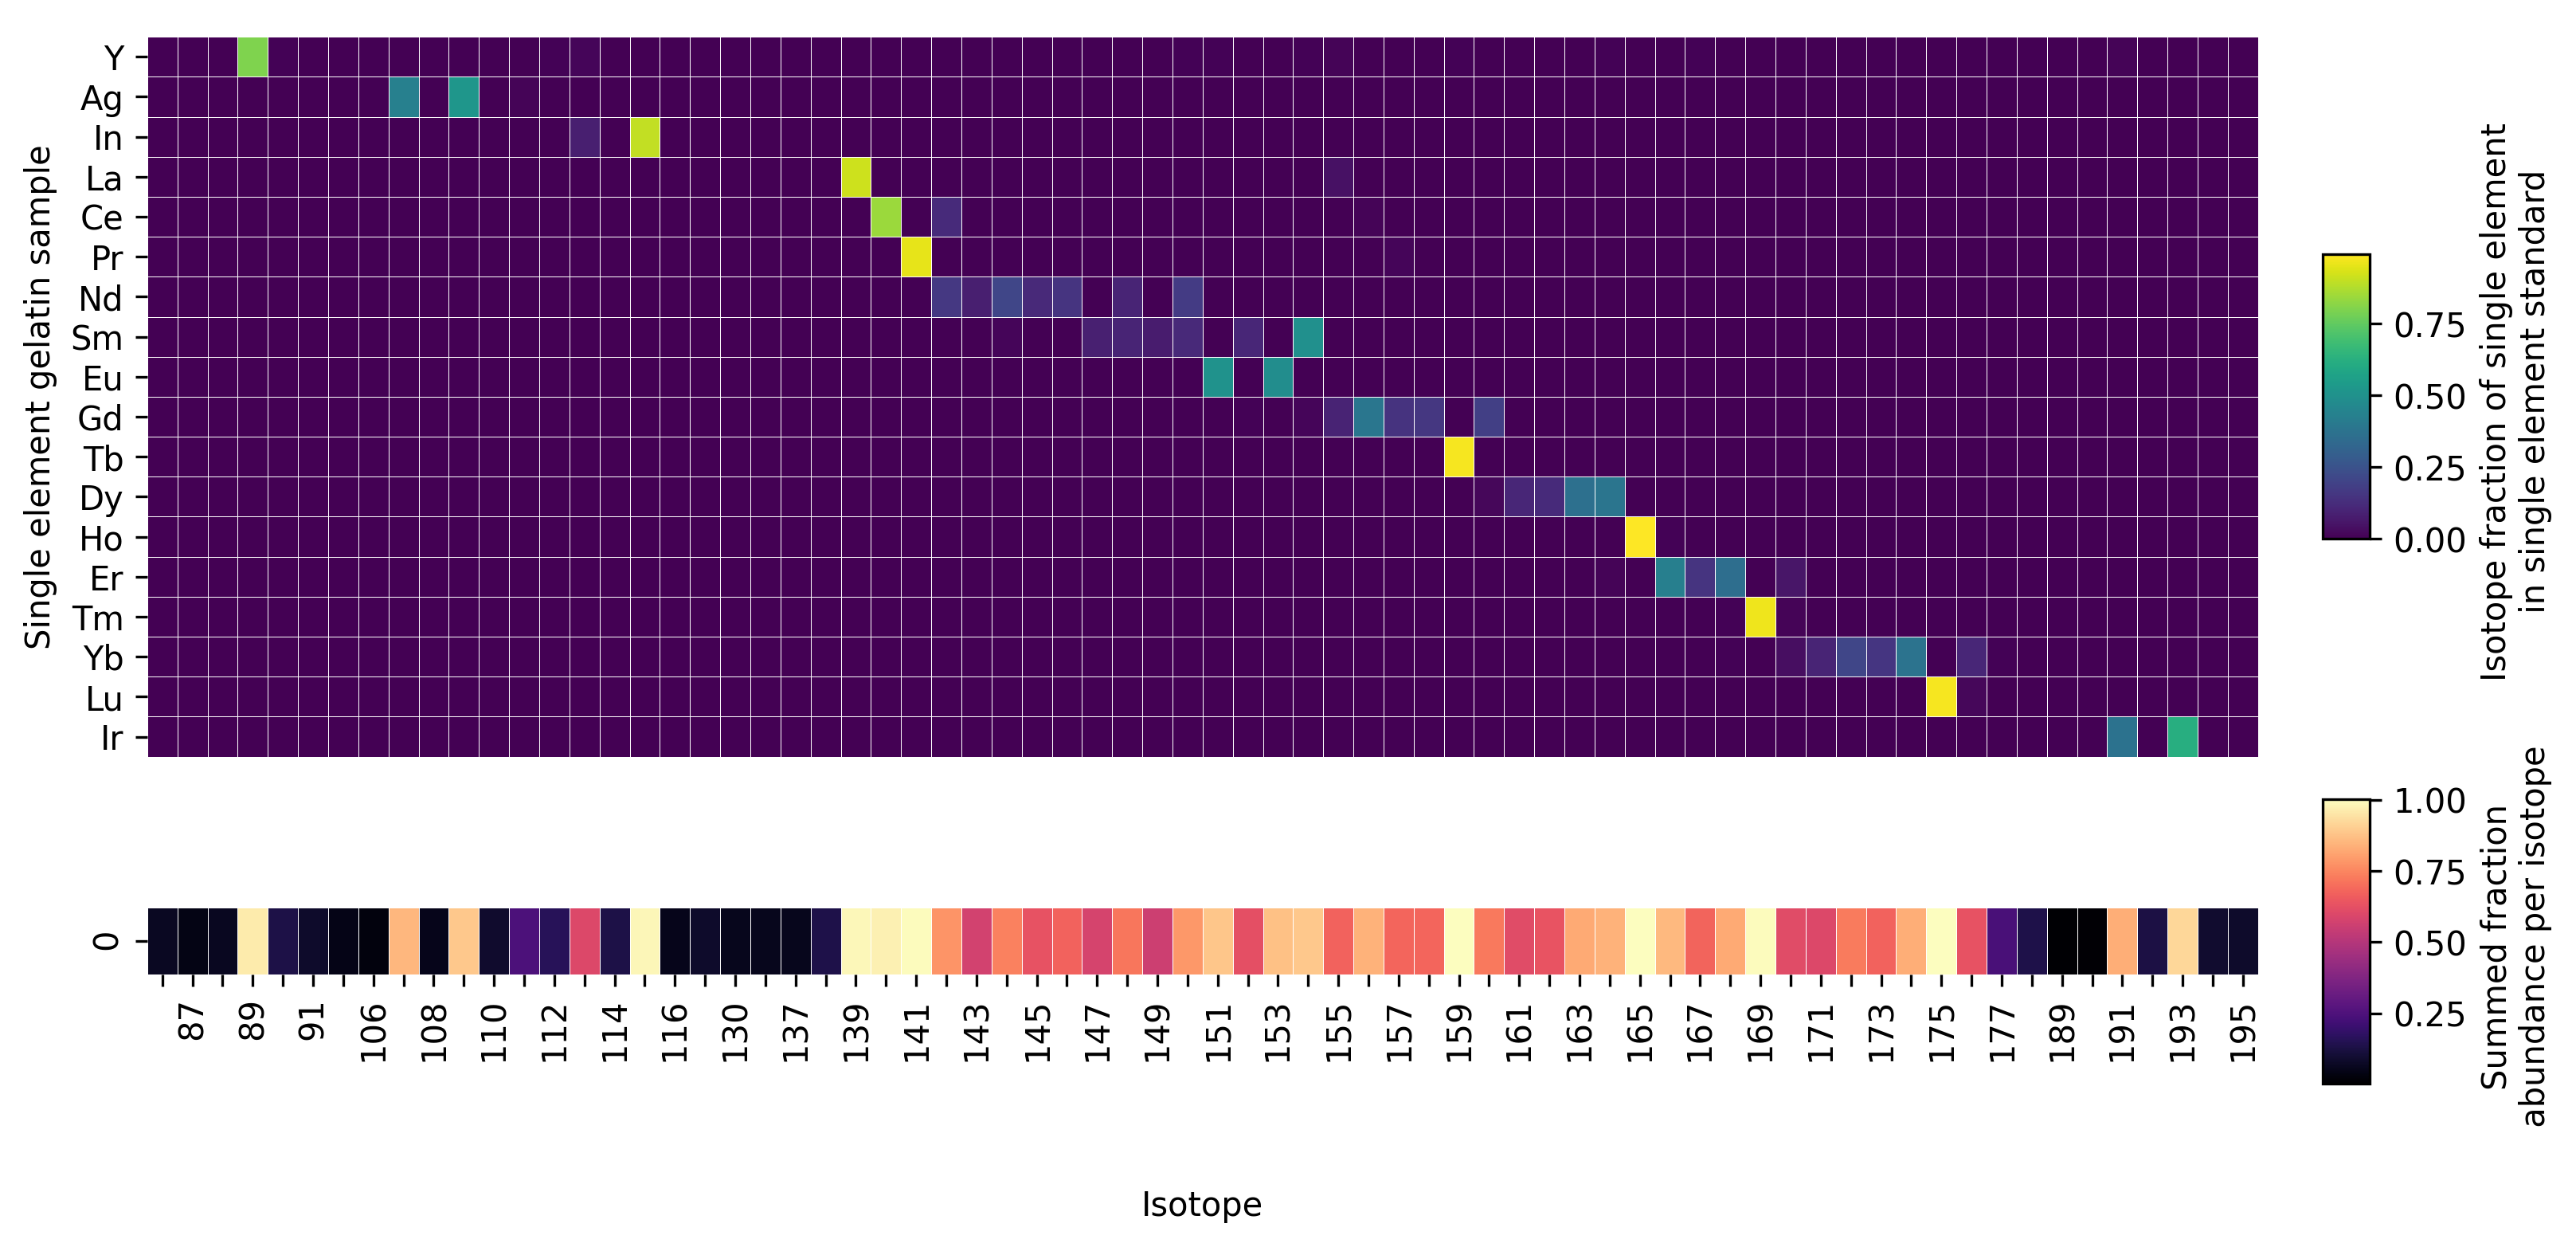

In [20]:
#import copy 
#from matplotlib.colors import LogNorm, Normalize

#df_norm_row = df_norm.apply(lambda x: (x/x.max()), axis = 0)
#df_norm_row = df_ele_isotopes.iloc[1:, :]

df_plot1 = df_ele_isotopes.iloc[1:,:].transpose()
df_plot1 = df_blank_div.iloc[1:,:].transpose()
df_plot1 = df_ele_iso_contibution.transpose()

fig = plt.figure(dpi=300, figsize=(12,6))
gs = fig.add_gridspec(30, 40)
f_pan_ax = fig.add_subplot(gs[:, :-2]) # large subplot for labels
f_ax1 = fig.add_subplot(gs[:-10, :-2]) # large heatmap
f_ax2 = fig.add_subplot(gs[-6:-4, :-2]) # bottom row heatmap
f_ax3 = fig.add_subplot(gs[-24:-16, -1:]) # colorbar 1
f_ax4 = fig.add_subplot(gs[-9:-1, -1:]) # colorbar 2

my_cmap1 = copy.copy(plt.cm.get_cmap('viridis')) # copy the default cmap
my_cmap1.set_bad(my_cmap1.colors[0]) # sets 'bad' or log0 values to cmap minimum

vmin1, vmax1 = np.percentile(df_plot1.values, [0, 100])

sns.heatmap(
    df_plot1,
    #norm=LogNorm(),
    xticklabels=False,
    cmap=my_cmap1,
    ax=f_ax1,
    vmin=vmin1,
    #vmin=0.1,
    vmax=vmax1,
    linewidths=.2,
    cbar=None
)
f_ax1.set_xlabel('')
f_ax1.set_ylabel('Single element gelatin sample')

my_cmap2 = copy.copy(plt.cm.get_cmap('magma')) # copy the default cmap
my_cmap2.set_bad(my_cmap2.colors[0]) # sets 'bad' or log0 values to cmap minimum

df_plot2 = df_plot1.sum(axis=0)
vmin2, vmax2 = np.percentile(df_plot2.values, [0, 100])

# Get column names
heatmap_cols = []
for count, i in enumerate(df_plot1.columns):
    if count % 2 != 1:
        heatmap_cols.append('')
    else:
        heatmap_cols.append(i)

sns.heatmap(
    df_plot2.values[np.newaxis, :],
    norm=LogNorm(),
    #xticklabels=False,
    cmap = my_cmap2,
    xticklabels=heatmap_cols,
    ax=f_ax2,
    #vmin=vmin,
    #vmax=vmax,
    linewidths=.2,
    cbar=None
)

fmt = mpl.ticker.ScalarFormatter(useOffset=1)

norm = mpl.colors.Normalize(vmin=vmin1, vmax=vmax1)
cb1 = mpl.colorbar.ColorbarBase(f_ax3, cmap=my_cmap1,
                                norm=norm,
                                orientation='vertical', format=fmt)
cb1.set_label('Isotope fraction of single element \n in single element standard')

norm = mpl.colors.Normalize(vmin=vmin2, vmax=vmax2)
cb2 = mpl.colorbar.ColorbarBase(f_ax4, cmap=my_cmap2,
                                norm=norm,
                                orientation='vertical')
cb2.set_label('Summed fraction \n abundance per isotope')

# Turn off axis lines and ticks of the big subplot
f_pan_ax.spines['top'].set_color('none')
f_pan_ax.spines['bottom'].set_color('none')
f_pan_ax.spines['left'].set_color('none')
f_pan_ax.spines['right'].set_color('none')
f_pan_ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
f_pan_ax.set_facecolor('w')

f_pan_ax.set_ylabel('')
f_pan_ax.set_xlabel('Isotope')

savename = out_dir / 'ExtF3a_IMCmetals.svg'
print(savename)
fig.savefig(savename, bbox_inches='tight')

plt.show()


In [21]:
# Get a percentage contribution to each isotope across single element samples
isotope_corr_factor = df_plot2.to_dict()

In [22]:
isotope_corr_factor

{80: 0.0052484295556462866,
 87: 0.004500599005825515,
 88: 0.005092335829083477,
 89: 0.802265794468549,
 90: 0.007478009071280782,
 91: 0.005742608936626325,
 105: 0.004642039331452739,
 106: 0.004179012495363325,
 107: 0.43131371500676013,
 108: 0.004845662329107717,
 109: 0.5254544635587249,
 110: 0.0058952812002312435,
 111: 0.013940030703931001,
 112: 0.008662475142471615,
 113: 0.10275750903386219,
 114: 0.007416046454246709,
 115: 0.9043568976856374,
 116: 0.004856035809327625,
 117: 0.005709460979270311,
 130: 0.004877033267458052,
 136: 0.004902315243022548,
 137: 0.004912072797217663,
 138: 0.007617124888993915,
 139: 0.9233496988503591,
 140: 0.8500521366120152,
 141: 0.9628514538182225,
 142: 0.2853261085289311,
 143: 0.08924531286306436,
 144: 0.22836942261055068,
 145: 0.12444369721571544,
 146: 0.15811898920630582,
 147: 0.0928193030570063,
 148: 0.20153125322816814,
 149: 0.08106349941520462,
 150: 0.30016126171283947,
 151: 0.5095599019319468,
 152: 0.1177174994397058

In [23]:
df_sample_standards = df_standard_measurements[
    (df_standard_measurements['sample_element'].isna())
].copy()

df_sample_standards['log_concentration'] = np.log(df_sample_standards['concentration_ppm'] + 1)
df_sample_standards['log_mean_counts'] = np.log(df_sample_standards['img_mean'] + 1)


In [24]:
isotopes = df_sample_standards['channel_mass'].unique()

print(df_sample_standards.columns)


Index(['mcd_filepath', 'acq_id', 'acq_id_description', 'step_um', 'x_dim',
       'y_dim', 'channel_name', 'channel_mass', 'img_mean', 'img_std',
       'sample_name', 'contents', 'contents_tidy', 'concentration_ppm',
       'sample_element', 'log_concentration', 'log_mean_counts'],
      dtype='object')


In [25]:
df_sample_standards

,mcd_filepath,acq_id,acq_id_description,step_um,x_dim,y_dim,channel_name,channel_mass,img_mean,img_std,sample_name,contents,contents_tidy,concentration_ppm,sample_element,log_concentration,log_mean_counts
0,C:\Users\MerrickS\OneDrive\Work\2_UZH\Papers\1...,1,101_200_0pt5um,0.5,100,100,ArAr80,80,5919.693848,261.784271,101,200,200,200.0,NaN,5.303305,8.686209
1,C:\Users\MerrickS\OneDrive\Work\2_UZH\Papers\1...,1,101_200_0pt5um,0.5,100,100,Sr87,87,0.486781,0.731519,101,200,200,200.0,NaN,5.303305,0.396614
2,C:\Users\MerrickS\OneDrive\Work\2_UZH\Papers\1...,1,101_200_0pt5um,0.5,100,100,Sr88,88,0.392474,0.673630,101,200,200,200.0,NaN,5.303305,0.331082
3,C:\Users\MerrickS\OneDrive\Work\2_UZH\Papers\1...,1,101_200_0pt5um,0.5,100,100,Y89,89,53.084457,10.135079,101,200,200,200.0,NaN,5.303305,3.990547
4,C:\Users\MerrickS\OneDrive\Work\2_UZH\Papers\1...,1,101_200_0pt5um,0.5,100,100,Zr90,90,0.337031,0.582037,101,200,200,200.0,NaN,5.303305,0.290451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6085,C:\Users\MerrickS\OneDrive\Work\2_UZH\Papers\1...,30,191_blank_2um,2.0,100,100,Ir191,191,0.014573,0.133325,191,blank,0,0.0,NaN,0.000000,0.014468
6086,C:\Users\MerrickS\OneDrive\Work\2_UZH\Papers\1...,30,191_blank_2um,2.0,100,100,Os192,192,0.015000,0.121552,191,blank,0,0.0,NaN,0.000000,0.014889
6087,C:\Users\MerrickS\OneDrive\Work\2_UZH\Papers\1...,30,191_blank_2um,2.0,100,100,Ir193,193,0.027304,0.213795,191,blank,0,0.0,NaN,0.000000,0.026938
6088,C:\Users\MerrickS\OneDrive\Work\2_UZH\Papers\1...,30,191_blank_2um,2.0,100,100,Pt194,194,0.010558,0.114109,191,blank,0,0.0,NaN,0.000000,0.010502


In [26]:
df_sample_standards.step_um.unique()

array([0.5, 1. , 2. ])

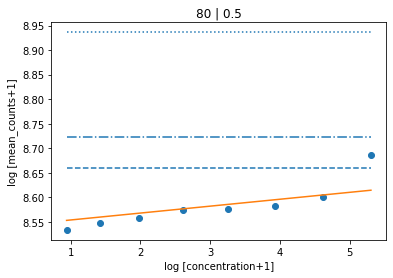

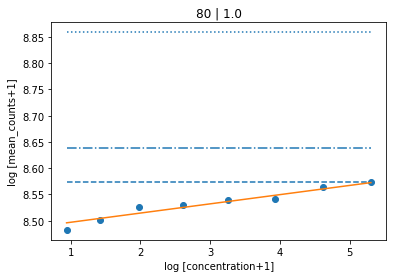

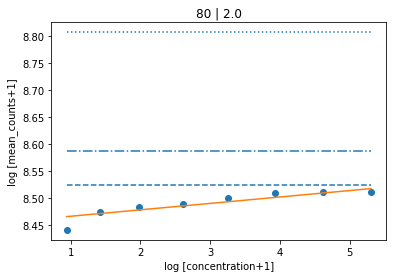

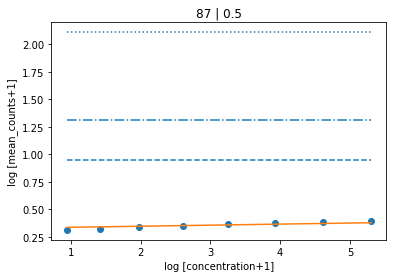

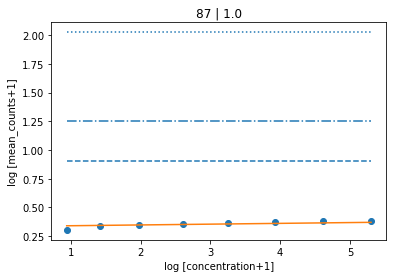

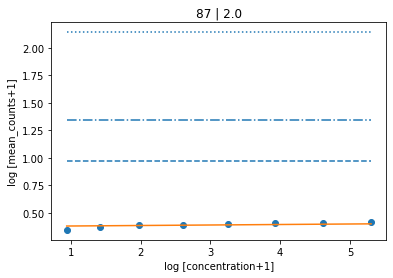

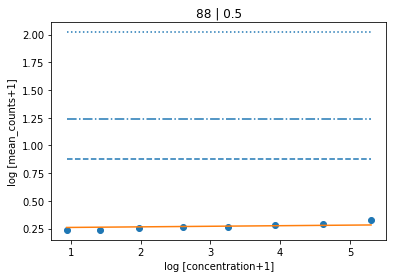

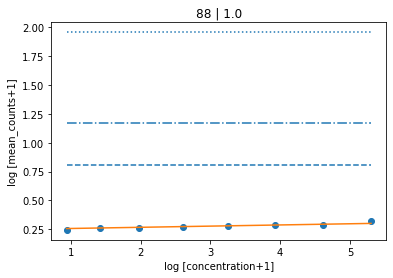

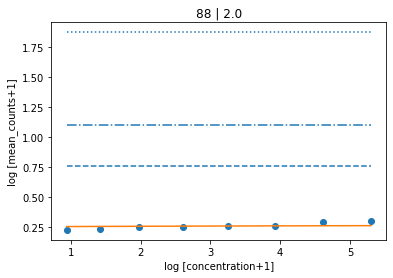

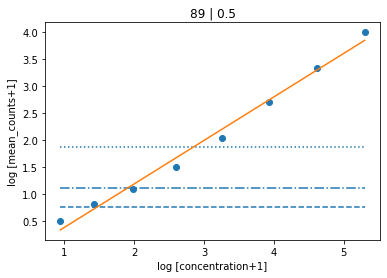

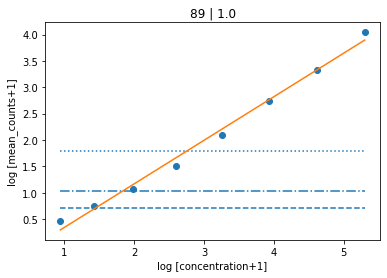

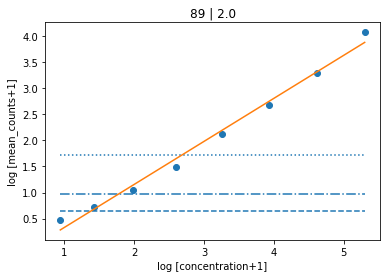

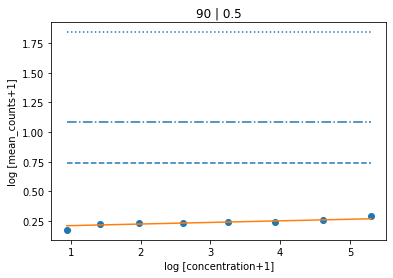

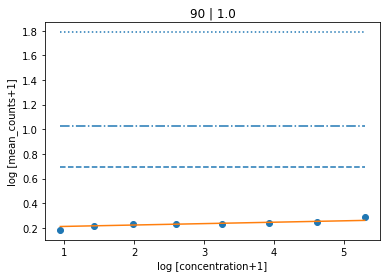

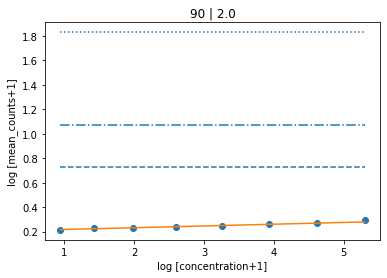

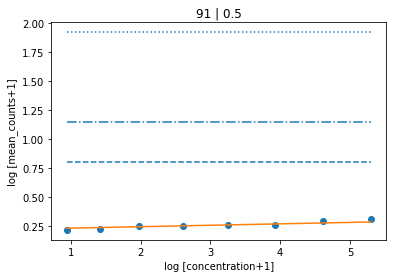

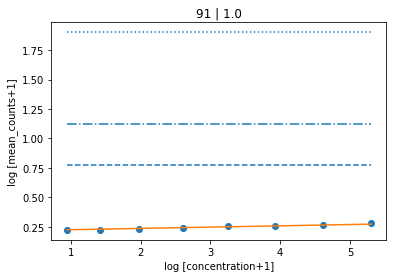

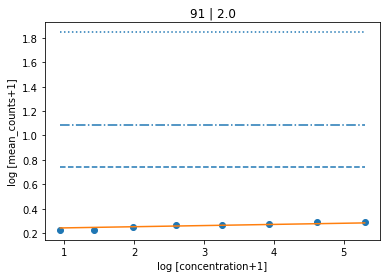

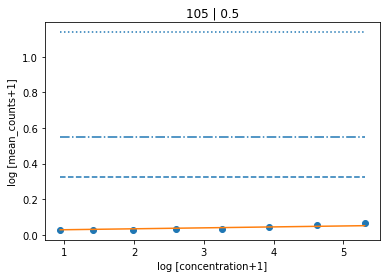

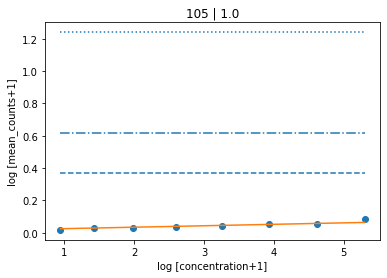

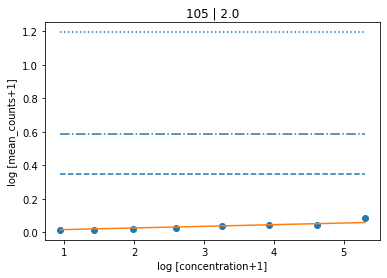

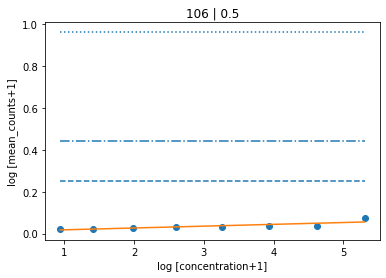

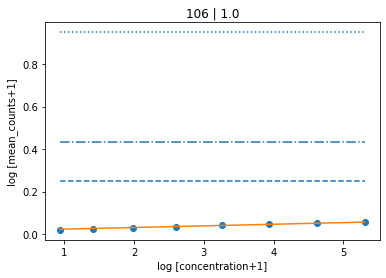

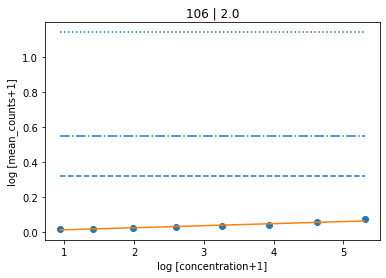

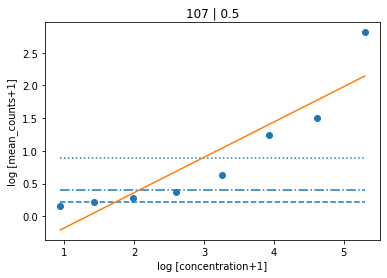

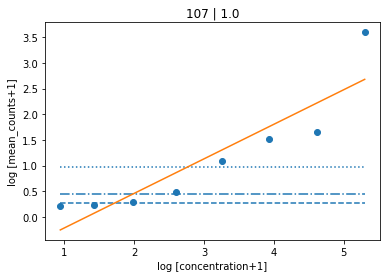

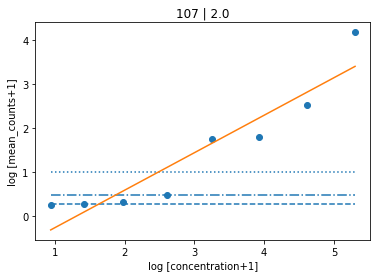

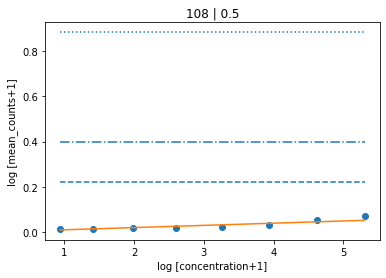

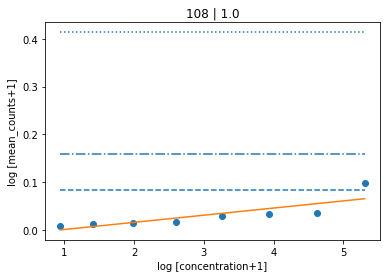

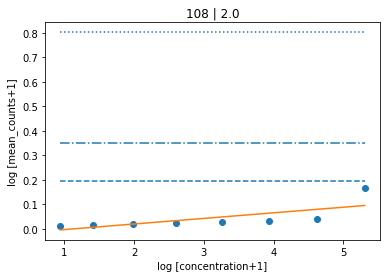

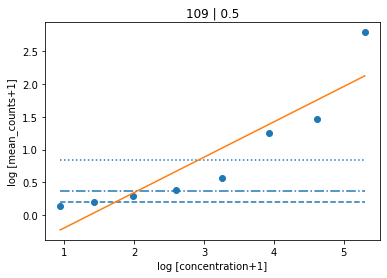

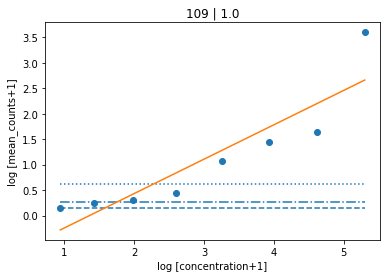

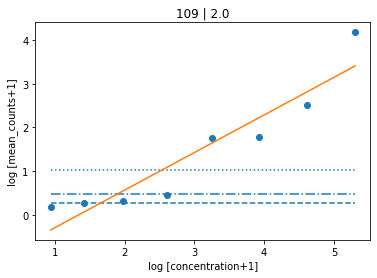

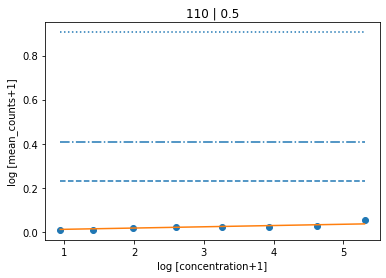

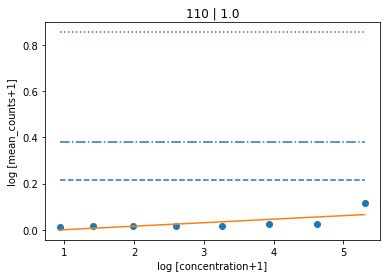

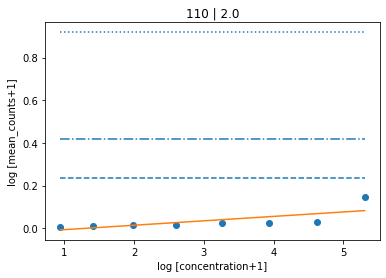

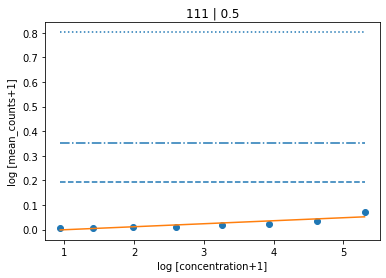

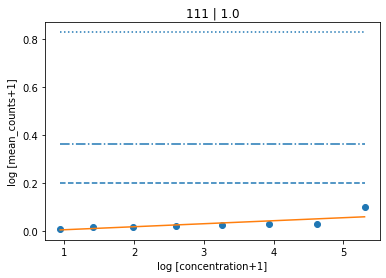

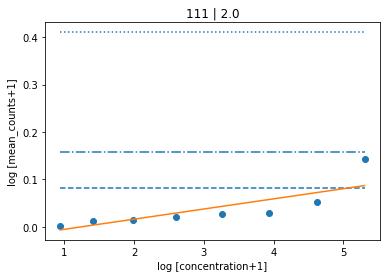

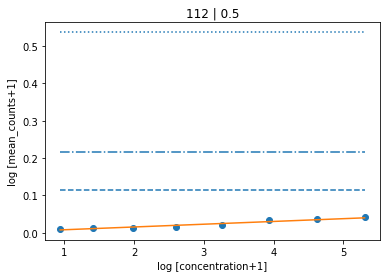

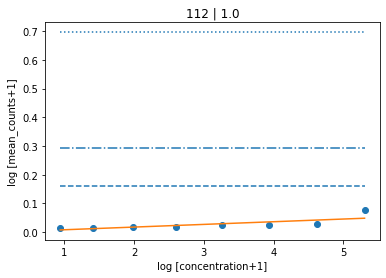

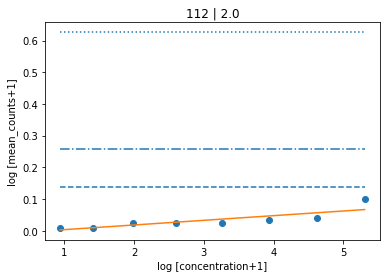

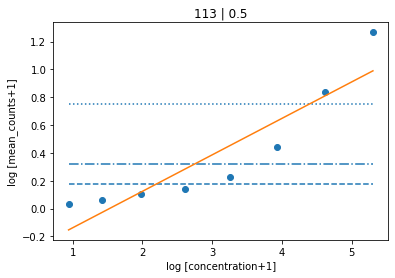

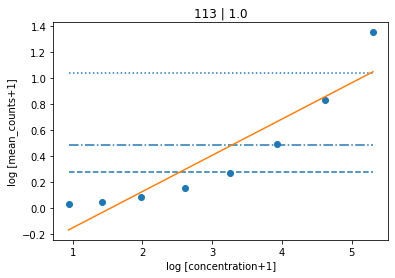

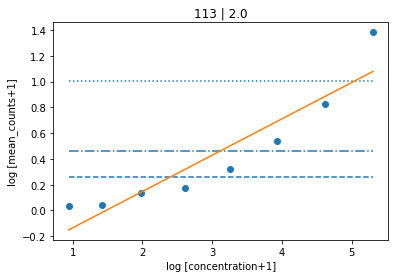

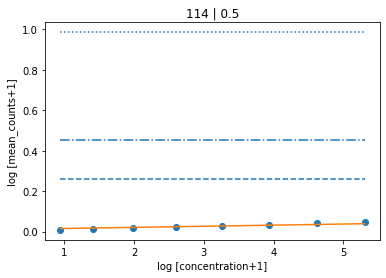

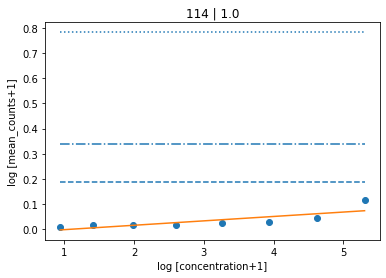

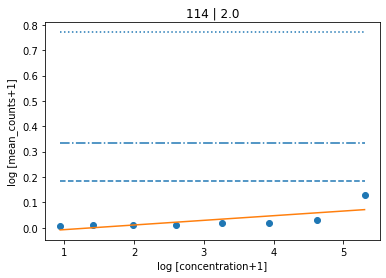

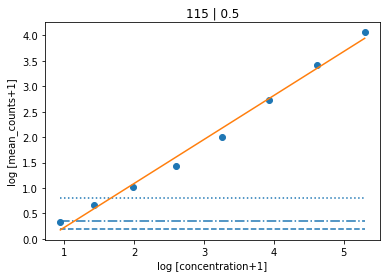

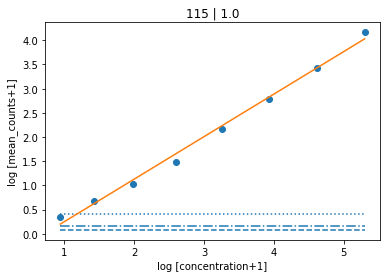

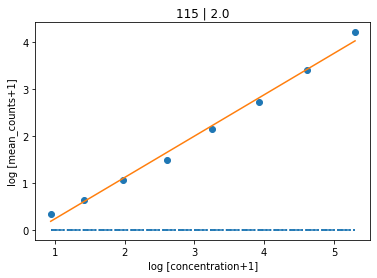

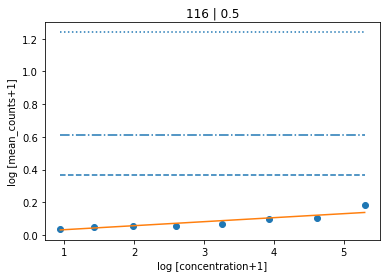

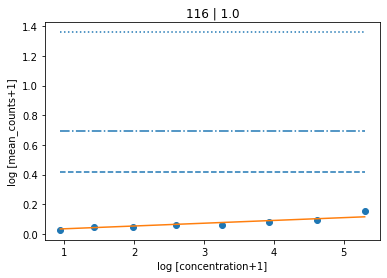

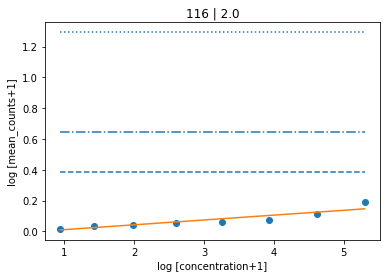

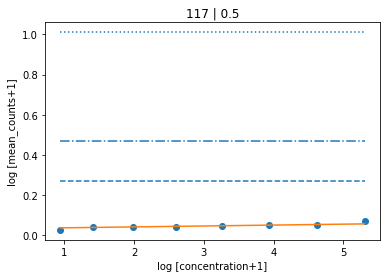

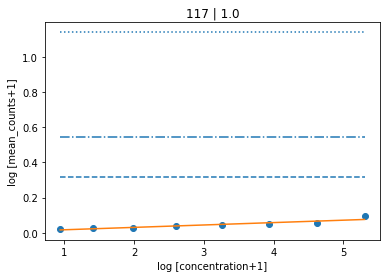

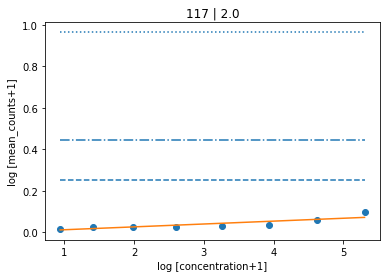

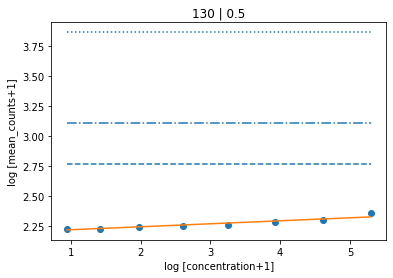

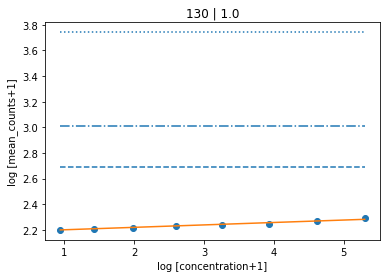

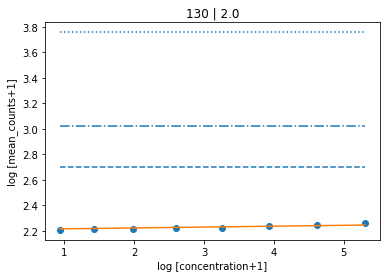

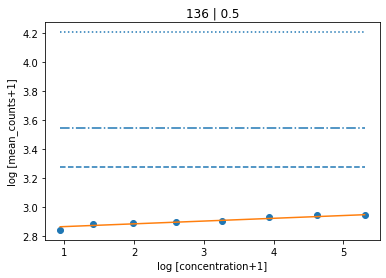

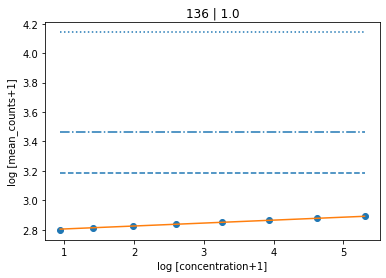

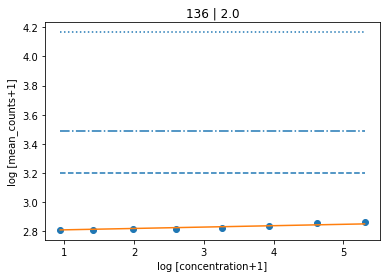

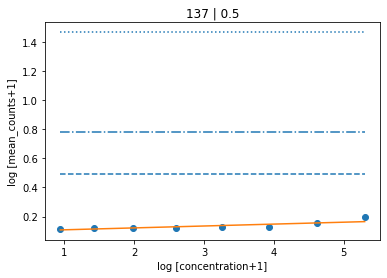

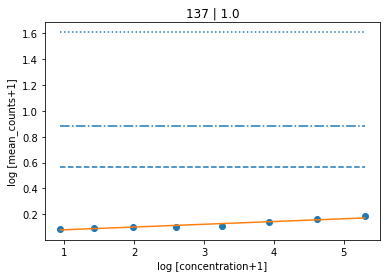

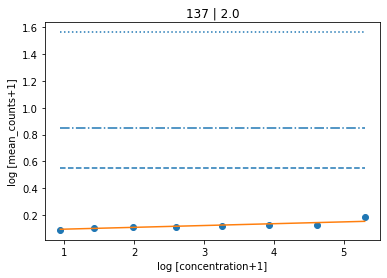

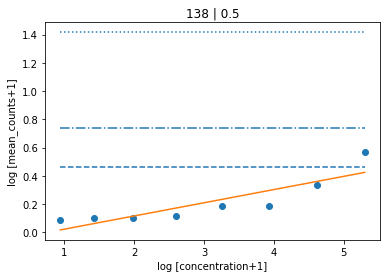

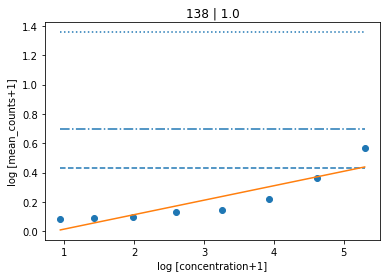

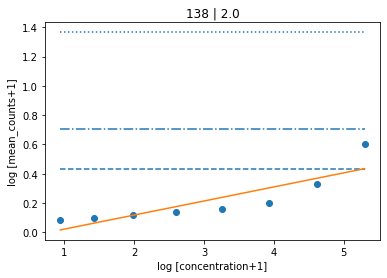

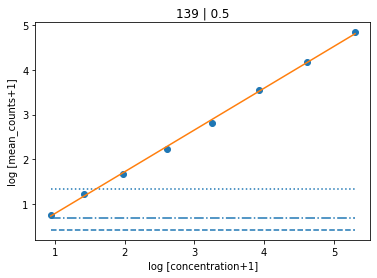

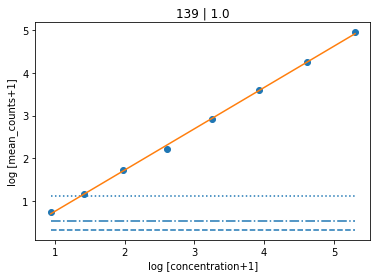

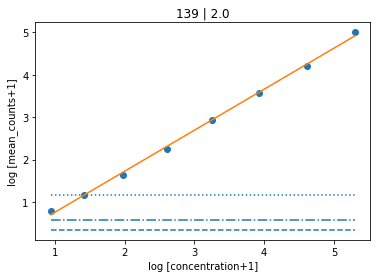

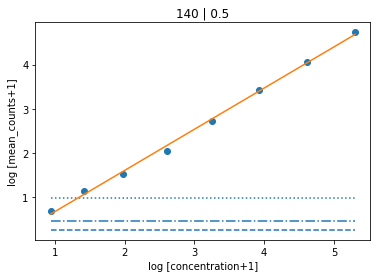

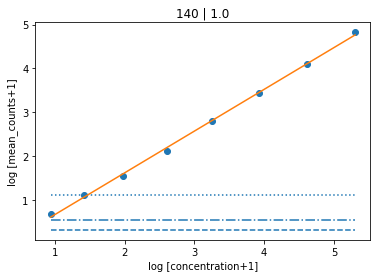

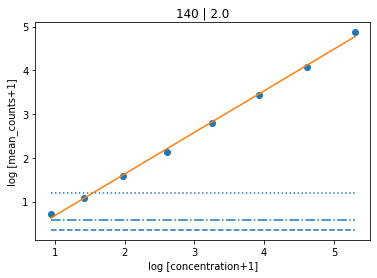

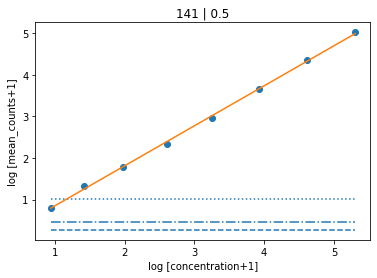

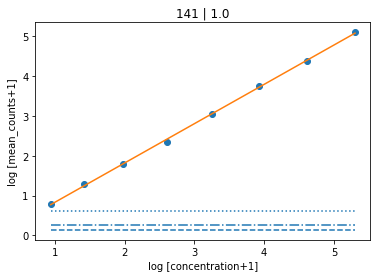

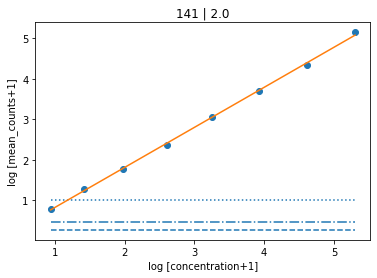

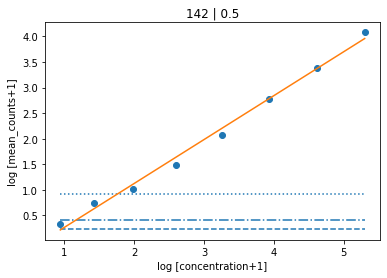

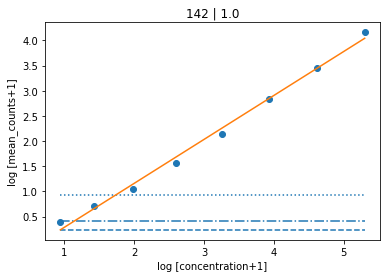

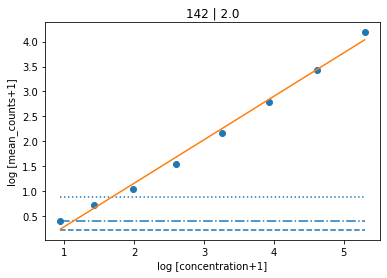

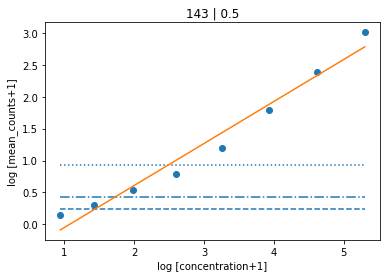

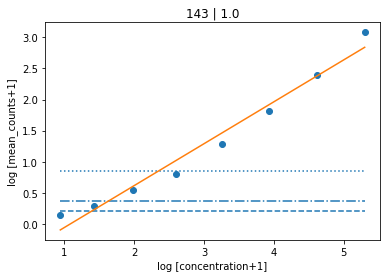

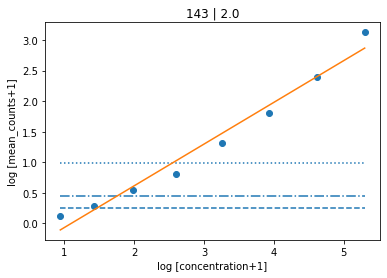

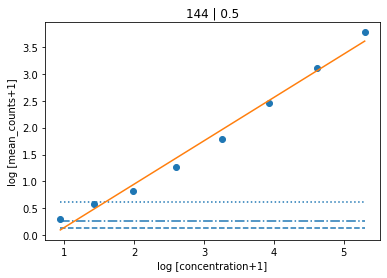

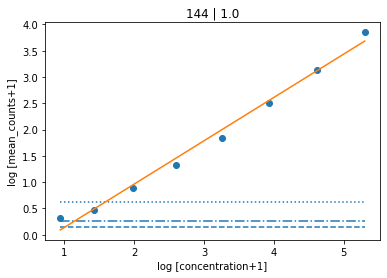

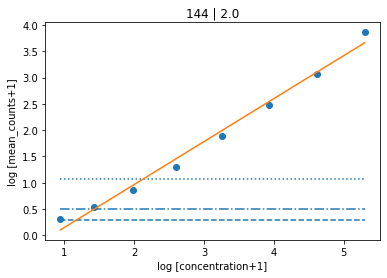

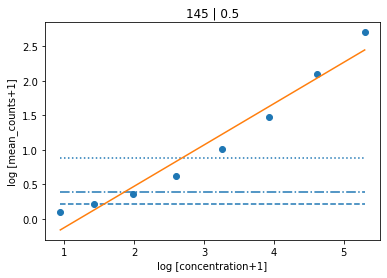

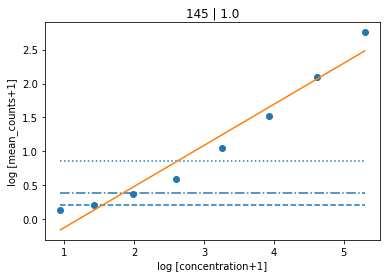

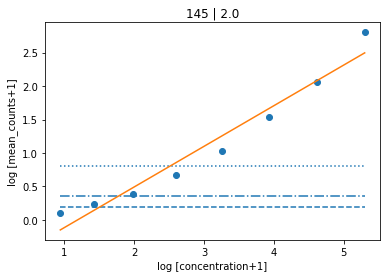

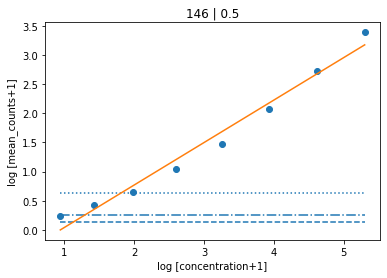

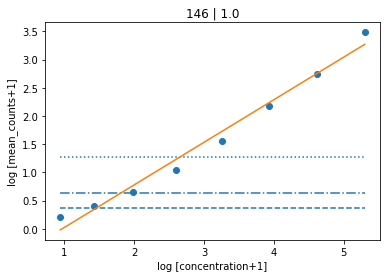

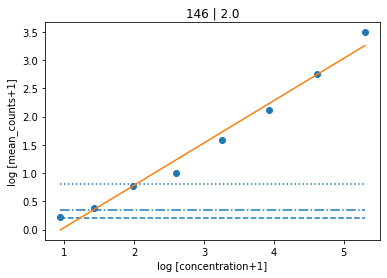

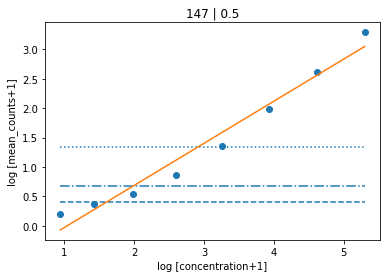

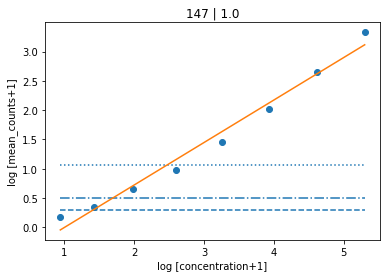

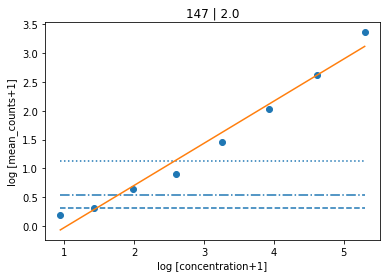

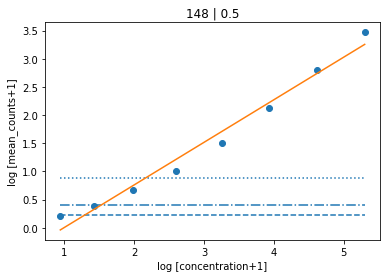

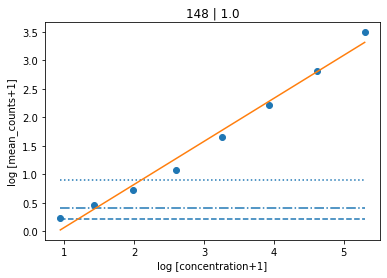

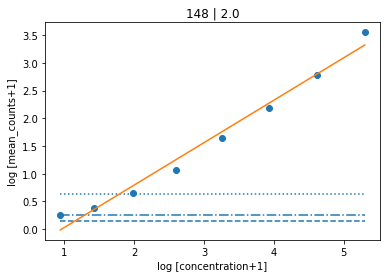

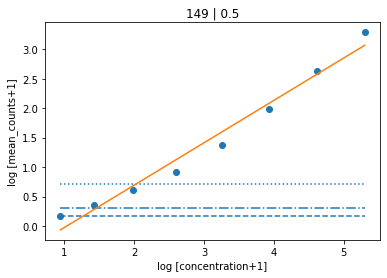

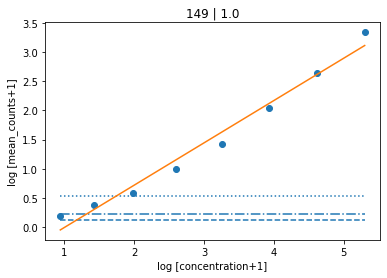

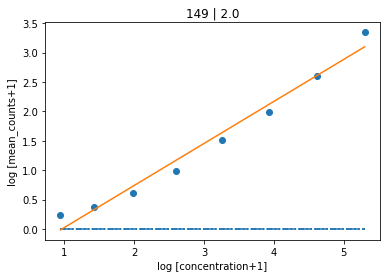

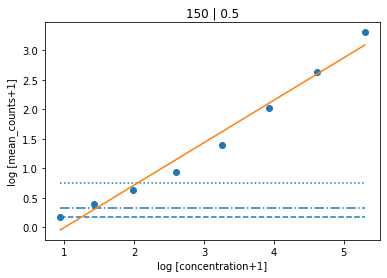

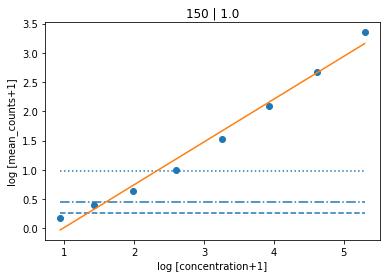

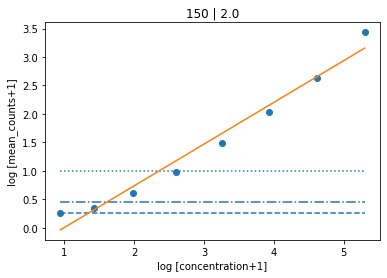

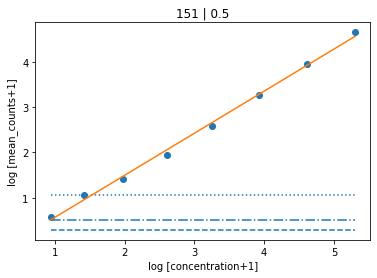

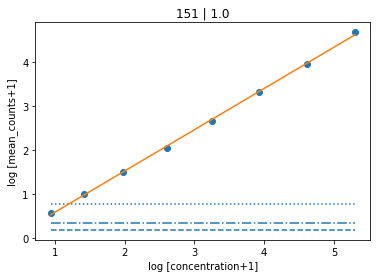

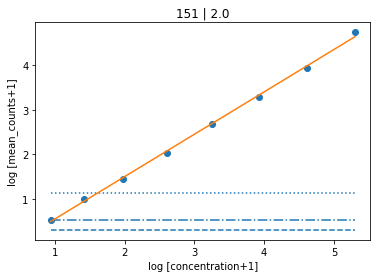

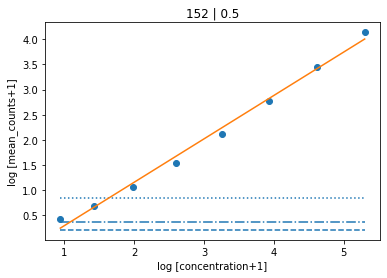

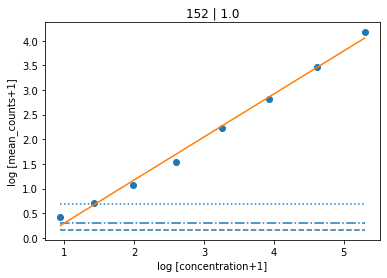

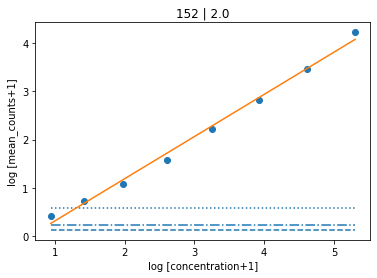

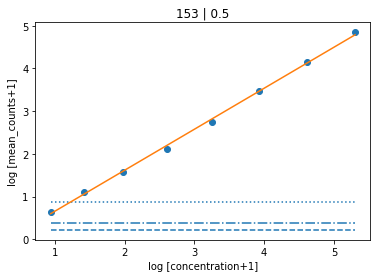

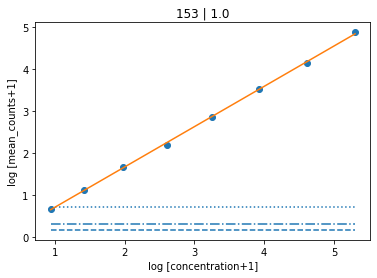

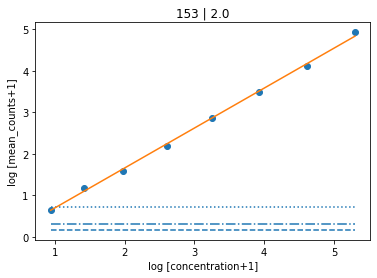

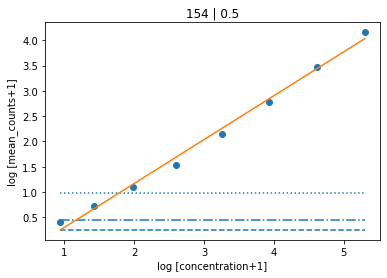

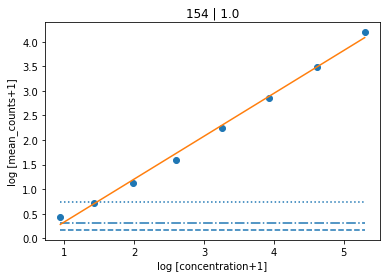

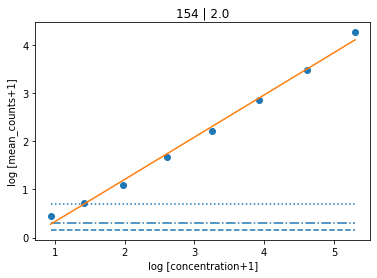

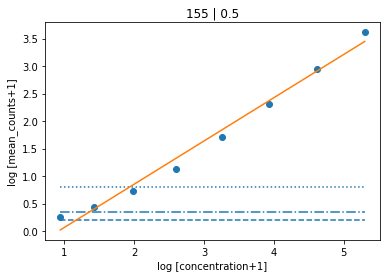

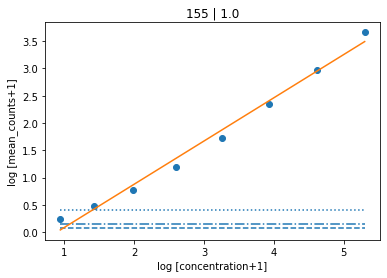

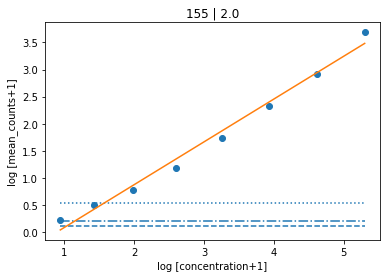

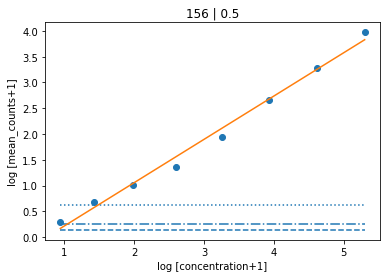

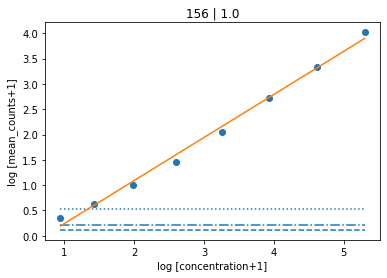

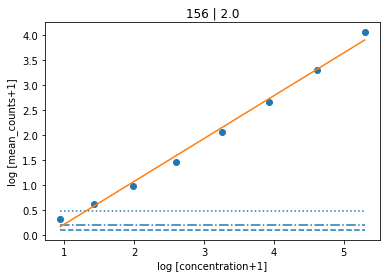

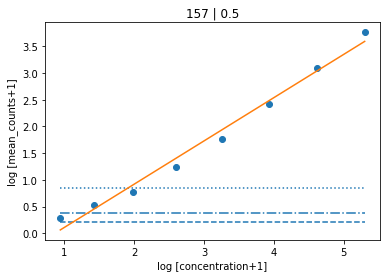

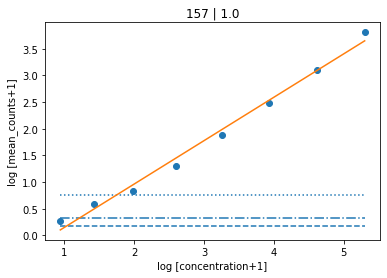

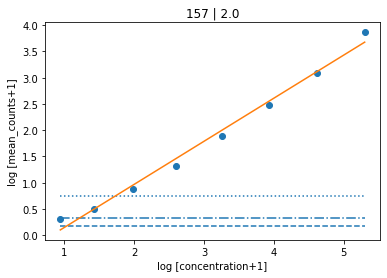

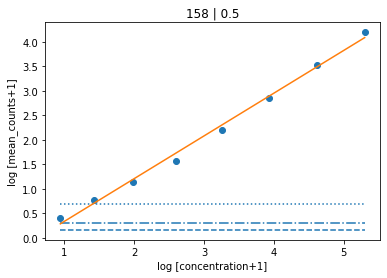

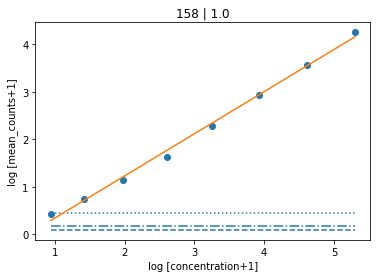

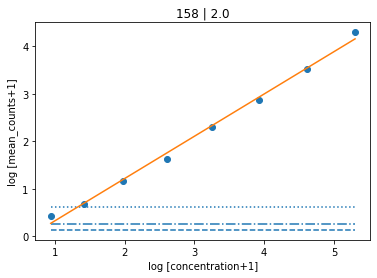

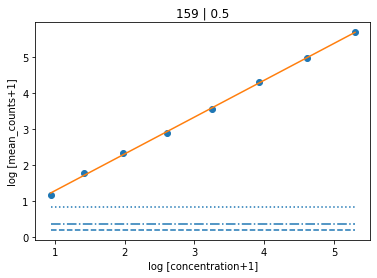

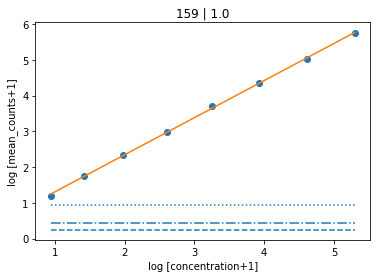

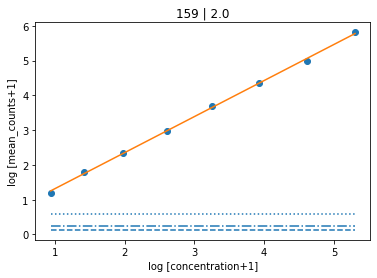

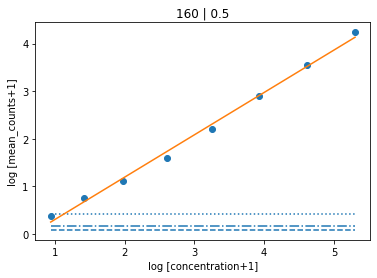

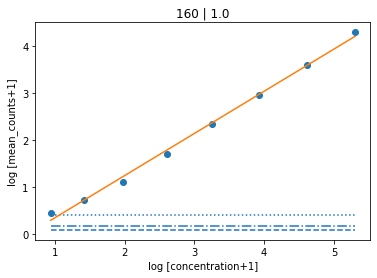

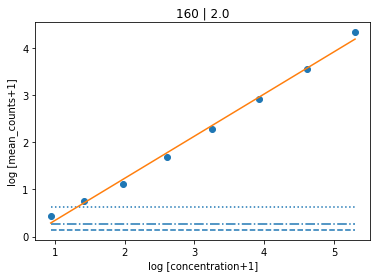

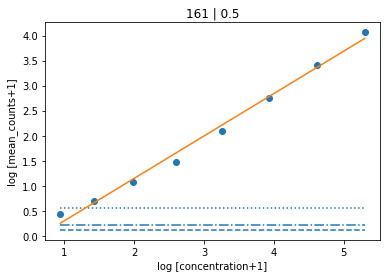

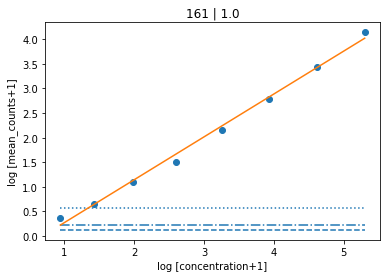

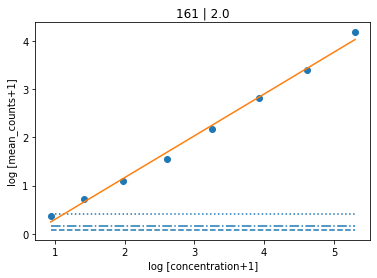

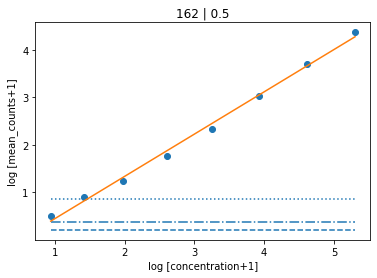

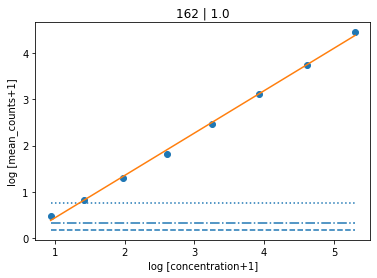

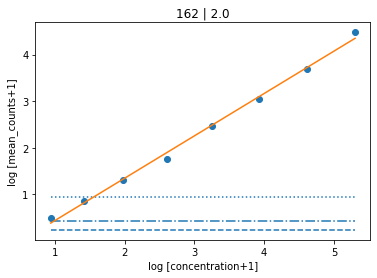

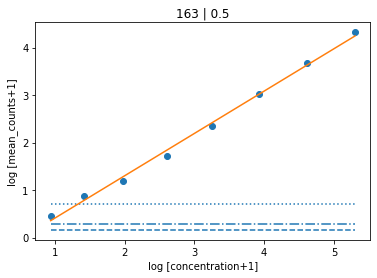

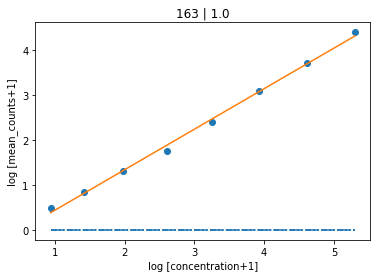

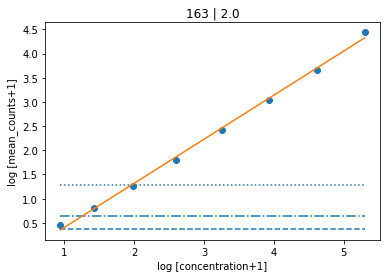

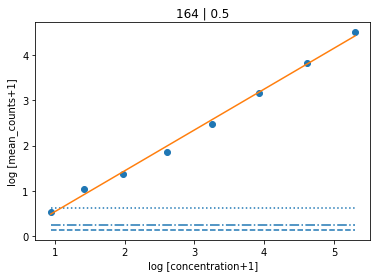

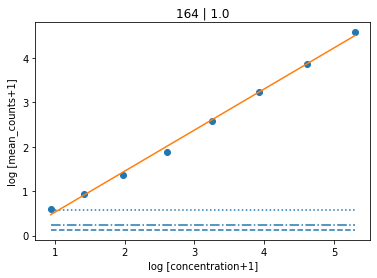

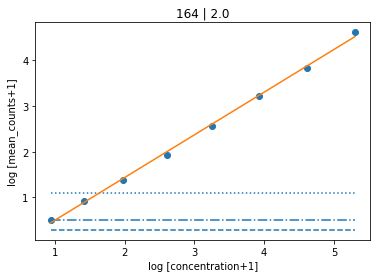

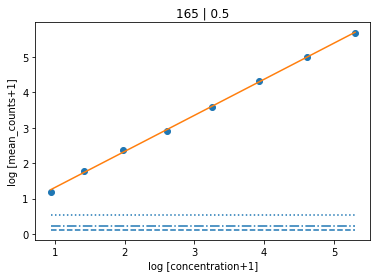

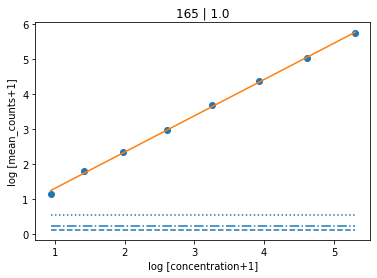

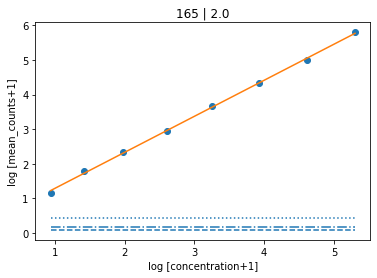

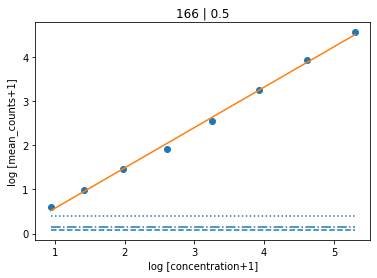

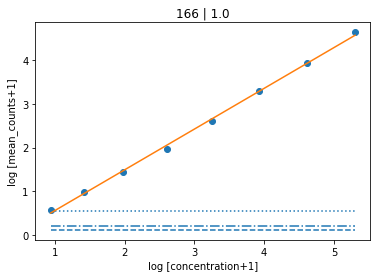

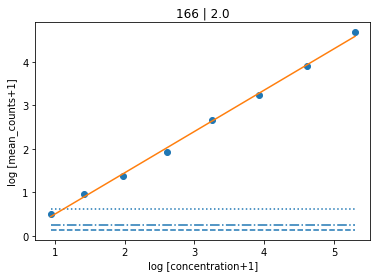

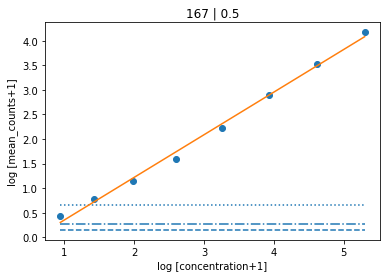

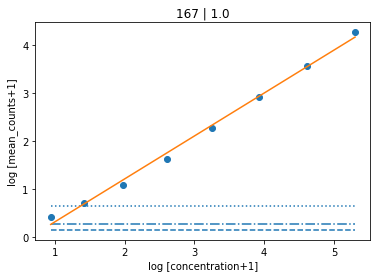

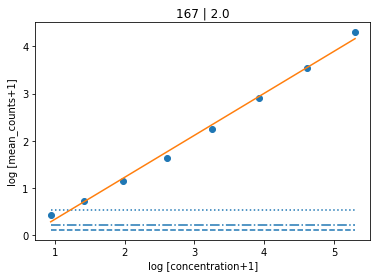

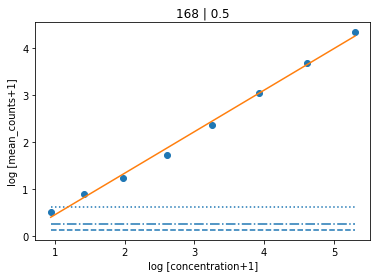

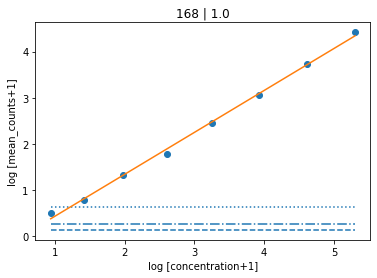

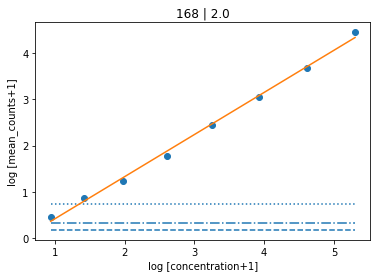

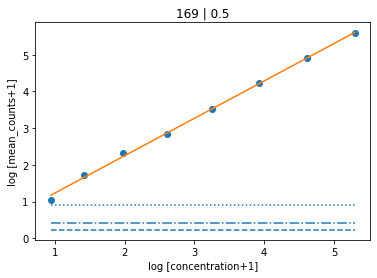

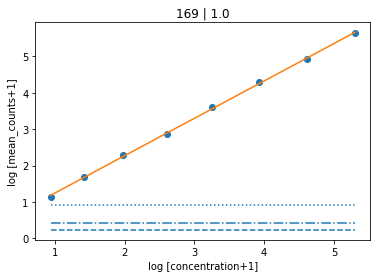

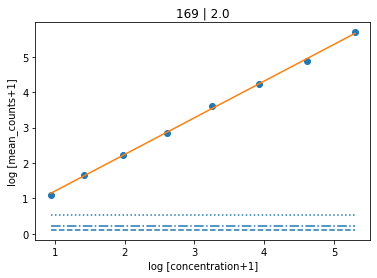

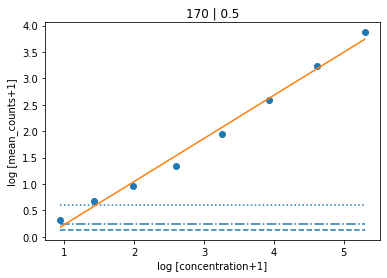

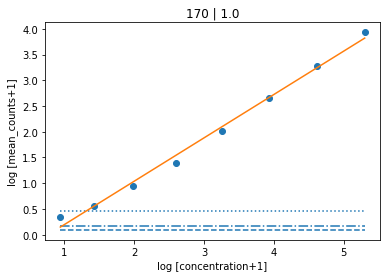

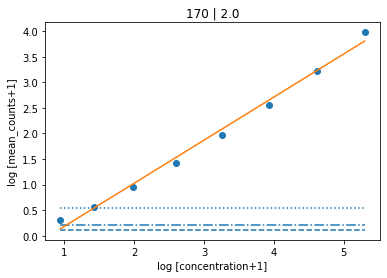

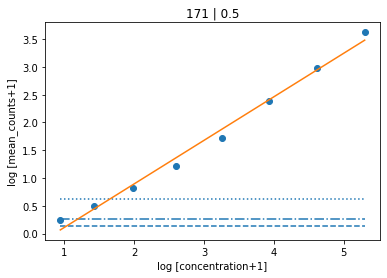

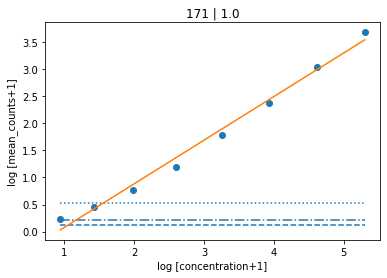

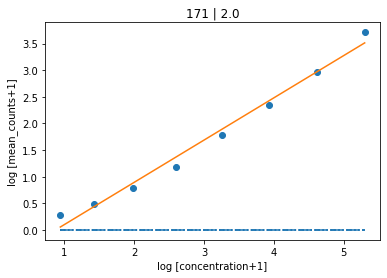

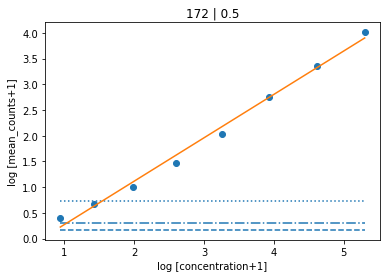

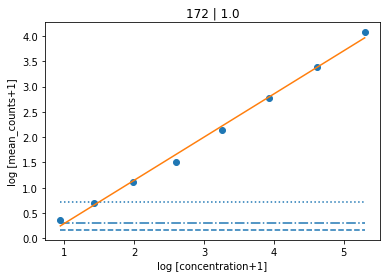

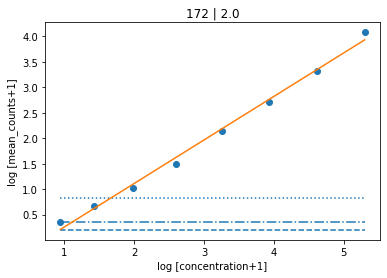

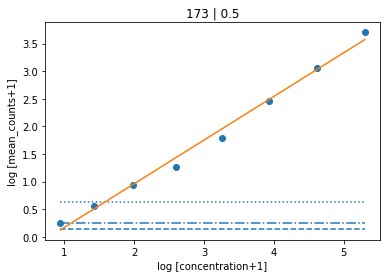

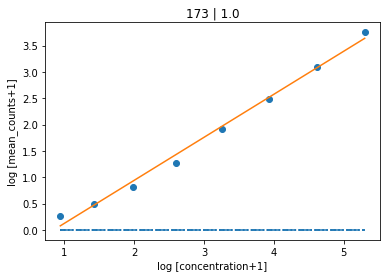

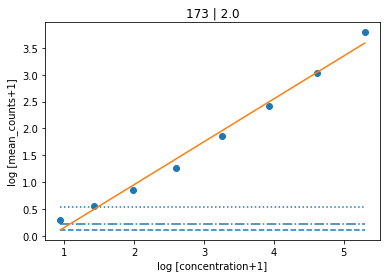

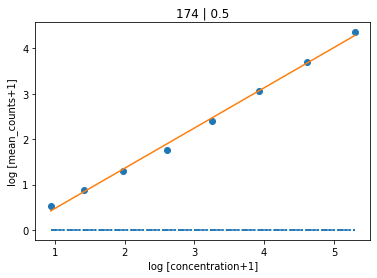

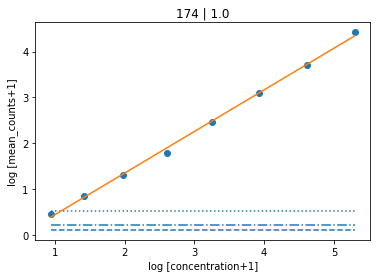

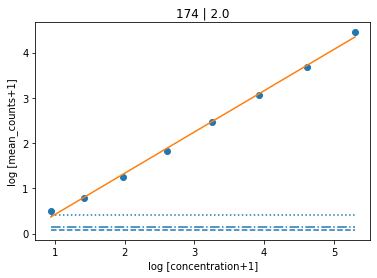

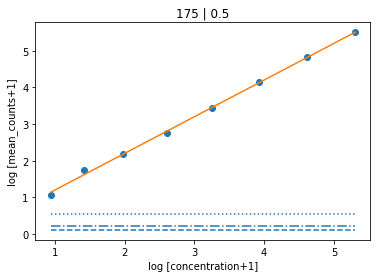

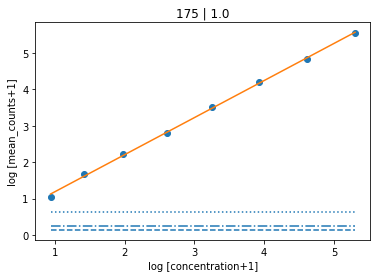

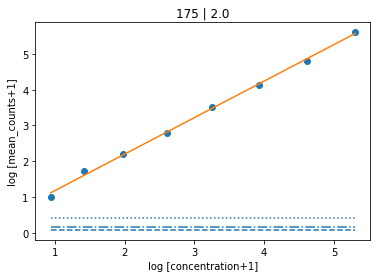

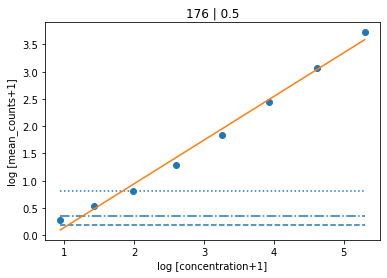

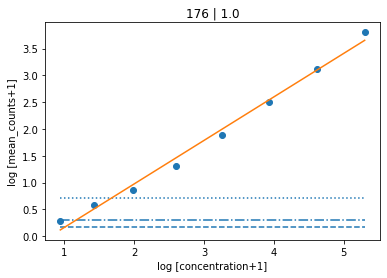

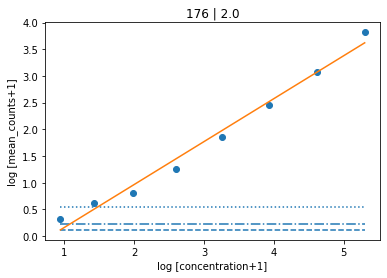

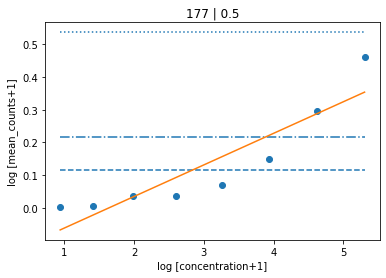

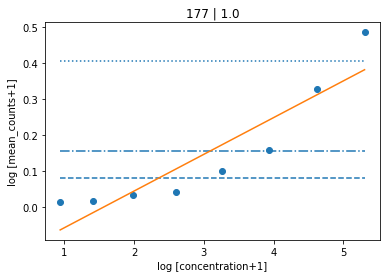

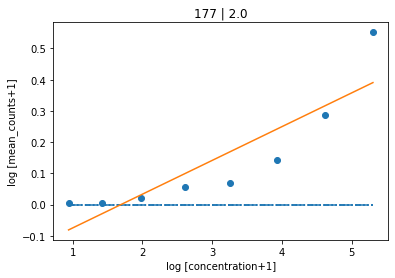

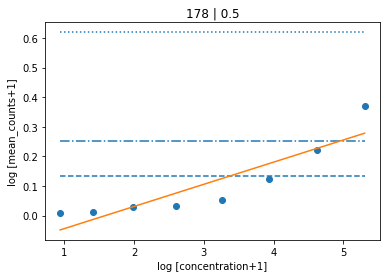

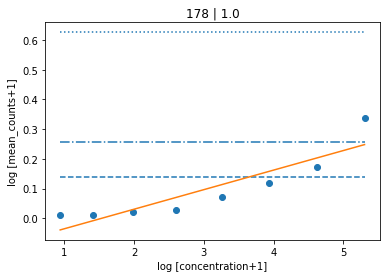

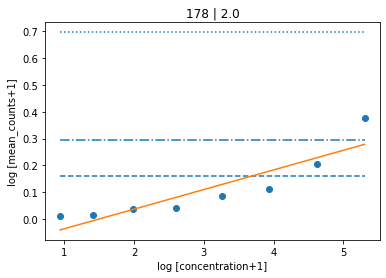

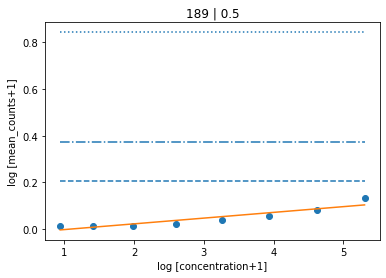

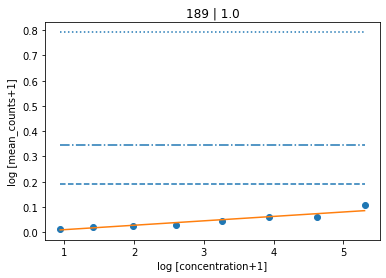

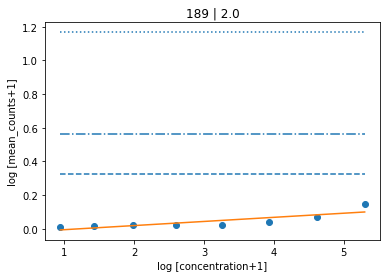

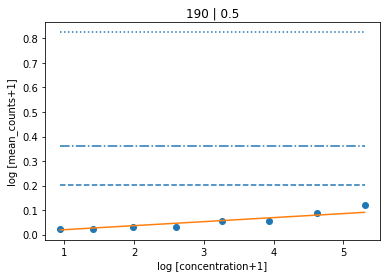

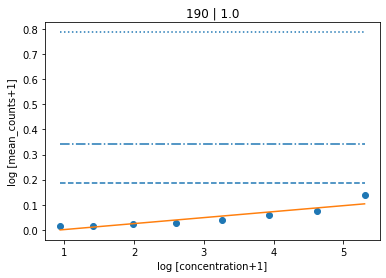

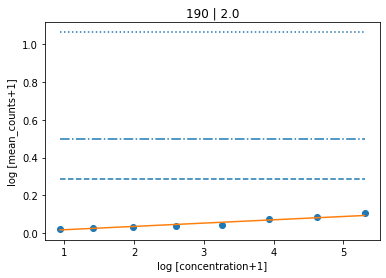

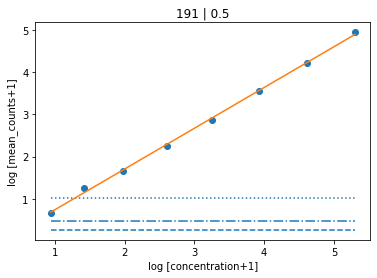

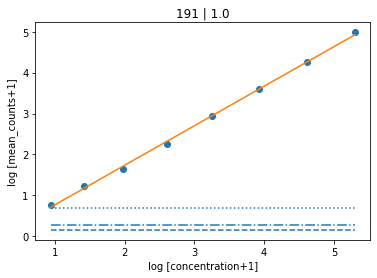

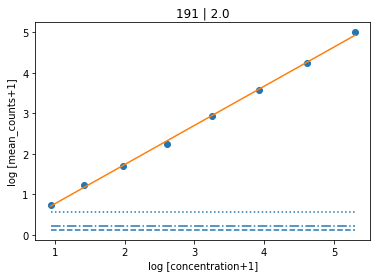

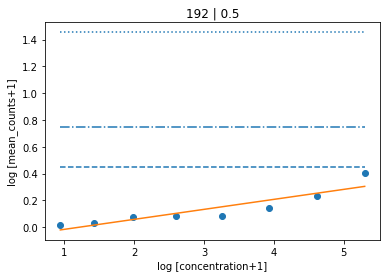

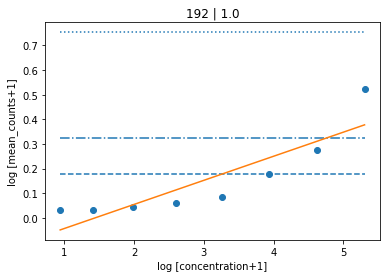

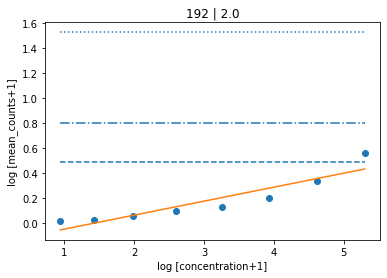

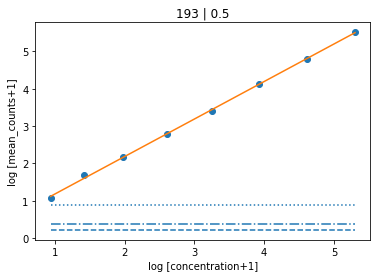

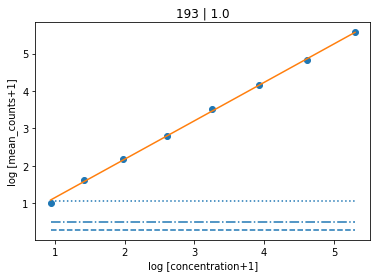

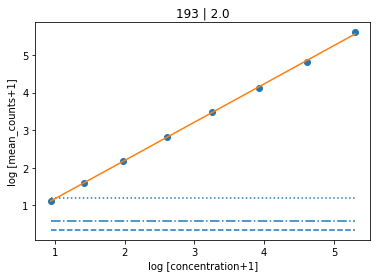

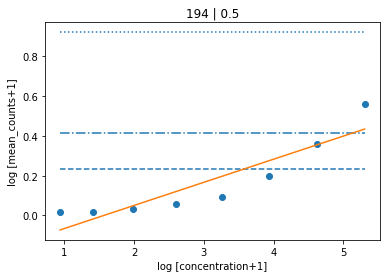

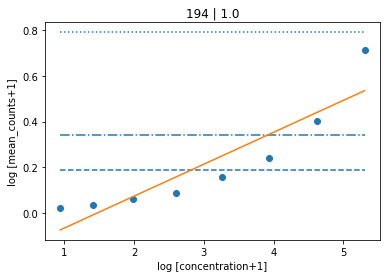

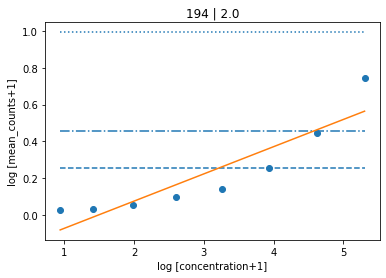

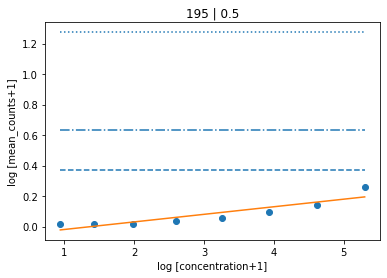

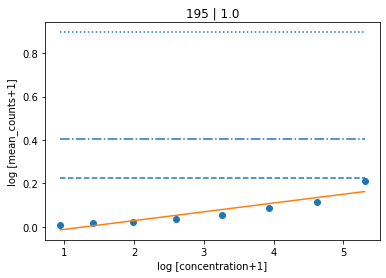

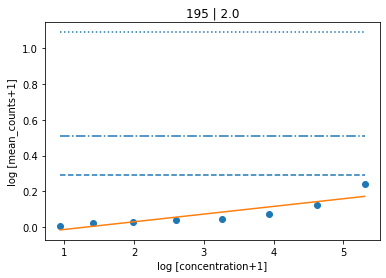

In [27]:
from numpy.polynomial import Polynomial

limits = [
    'isotope', 
    'step_um',
    'blank_counts', 
    'blank_std', 
    'lob_intercept', 
    'lod_intercept', 
    'loq_intercept',
    'lob_concentration', 
    'lod_concentration', 
    'loq_concentration', 
]

df_detection_limits = pd.DataFrame(columns=limits)

for isotope in isotopes:
    for step_um in df_sample_standards.step_um.unique():
        limits_dict = dict.fromkeys(limits)
        limits_dict['isotope'] = int(isotope)
        limits_dict['step_um'] = float(step_um)

        df_isotope = df_sample_standards[
            (df_sample_standards['log_concentration'] != 0)
            & (df_sample_standards['channel_mass'] == isotope)
            & (df_sample_standards['step_um'] == step_um)
        ]

        df_isotope_blank = df_sample_standards[
            (df_sample_standards['concentration_ppm'] == 0)
            & (df_sample_standards['channel_mass'] == isotope)
            & (df_sample_standards['step_um'] == step_um)
        ]

        limits_dict['blank_counts'] = df_isotope_blank['img_mean'].iloc[0]
        limits_dict['blank_std'] = df_isotope_blank['img_std'].iloc[0]

        x_data = df_isotope['log_concentration']
        y_data = df_isotope['log_mean_counts']

        x1 = np.sort(x_data, 0)
        y1 = np.sort(y_data, 0)
        plt.plot(x1, y1, 'o')

        p = Polynomial.fit(x_data, y_data, deg=1)        
        x2 = np.sort(x_data, 0)
        y2 = np.sort(p(x_data), 0)
        plt.plot(x2, y2)

        lob = np.log(limits_dict['blank_counts'] + 1.645*limits_dict['blank_std'] + 1)
        lod = np.log(limits_dict['blank_counts'] + 3.33*limits_dict['blank_std'] + 1)
        loq = np.log(limits_dict['blank_counts'] + 10*limits_dict['blank_std'] + 1)

        plt.hlines(lob, xmin = min(x_data), xmax = max(x_data), linestyles = 'dashed')
        plt.hlines(lod, xmin = min(x_data), xmax = max(x_data), linestyles = 'dashdot')
        plt.hlines(loq, xmin = min(x_data), xmax = max(x_data), linestyles = 'dotted')

        # Record concentration where regression line intercepts limit of choice
        limits_dict['lob_intercept'] = (p-lob).roots()[-1]
        limits_dict['lod_intercept'] = (p-lod).roots()[-1]
        limits_dict['loq_intercept'] = (p-loq).roots()[-1]

        # Convert to conecntrations
        limits_dict['lob_concentration'] = np.exp(limits_dict['lob_intercept'] - 1)
        limits_dict['lod_concentration'] = np.exp(limits_dict['lod_intercept'] - 1)
        limits_dict['loq_concentration'] = np.exp(limits_dict['loq_intercept'] - 1)

        plt.xlabel('log [concentration+1]')
        plt.ylabel('log [mean_counts+1]')
        plt.title(f'{isotope} | {step_um}')
        plt.show()

        df_detection_limits = df_detection_limits.append(limits_dict, ignore_index=True)



In [28]:
df_detection_limits['correction_factor'] = df_detection_limits['isotope'].map(isotope_corr_factor)
df_detection_limits['Detector'] = 'IMC'

In [29]:
max(isotope_corr_factor.values())

1.0033731025282353

In [30]:
df_detection_limits['lob_concentration_corrected'] = (
    df_detection_limits['lob_concentration'] * df_detection_limits['correction_factor']
)


In [31]:
df_detection_limits.tail(10)

,isotope,step_um,blank_counts,blank_std,lob_intercept,lod_intercept,loq_intercept,lob_concentration,lod_concentration,loq_concentration,correction_factor,Detector,lob_concentration_corrected
200,192.0,2.0,0.043685,0.355405,5.790388,8.597910,15.095549,120.348074,1994.024040,1.323181e+06,0.007354,IMC,0.885084
201,193.0,0.5,0.015134,0.137596,0.043775,0.214093,0.695766,0.384341,0.455706,7.376884e-01,0.627001,IMC,0.240982
202,193.0,1.0,0.026117,0.190706,0.161305,0.370850,0.925044,0.432274,0.533045,9.277841e-01,0.627001,IMC,0.271036
203,193.0,2.0,0.035188,0.230279,0.187592,0.425512,1.030363,0.443788,0.562993,1.030829e+00,0.627001,IMC,0.278256
204,194.0,0.5,0.014390,0.149757,3.560332,5.129936,9.490919,12.940117,62.173918,4.870341e+03,0.005930,IMC,0.076734
205,194.0,1.0,0.011848,0.119347,2.824464,3.926600,7.132105,6.199472,18.664066,4.604044e+02,0.005930,IMC,0.036762
206,194.0,2.0,0.017597,0.168102,3.227200,4.567522,8.203790,9.273860,35.428678,1.344517e+03,0.005930,IMC,0.054993
207,195.0,0.5,0.030297,0.254802,8.859056,14.083804,27.058143,2589.074049,481087.343338,2.074473e+11,0.005684,IMC,14.716511
208,195.0,1.0,0.018923,0.143069,6.889745,11.230489,23.417489,361.313189,27736.071981,5.442415e+09,0.005684,IMC,2.053734
209,195.0,2.0,0.015787,0.195238,8.051214,13.182307,26.653488,1154.259174,195302.899541,1.384103e+11,0.005684,IMC,6.560905


In [32]:
used_isotopes = list(range(139, 175, 1))
used_isotopes = used_isotopes + [
    89,
    107,
    109,
    113,
    115,
    191,
    193
]

In [33]:
df_detection_limits_select = df_detection_limits[
    df_detection_limits['isotope'].isin(used_isotopes)
]

In [34]:
df_detection_limits_select

,isotope,step_um,blank_counts,blank_std,lob_intercept,lod_intercept,loq_intercept,lob_concentration,lod_concentration,loq_concentration,correction_factor,Detector,lob_concentration_corrected
9,89.0,0.5,0.272512,0.519107,1.468527,1.896642,2.849928,1.597639,2.451357,6.359364,0.802266,IMC,1.281731
10,89.0,1.0,0.247164,0.476162,1.441553,1.845097,2.756353,1.555120,2.328204,5.791280,0.802266,IMC,1.247620
11,89.0,2.0,0.194275,0.434191,1.381540,1.775000,2.672834,1.464539,2.170592,5.327246,0.802266,IMC,1.174949
24,107.0,0.5,0.020000,0.140000,1.744317,2.064679,2.968356,2.105004,2.899908,7.158898,0.431314,IMC,0.907917
25,107.0,1.0,0.027995,0.163751,1.707645,1.994210,2.777720,2.029208,2.702589,5.916353,0.431314,IMC,0.875225
...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,191.0,1.0,0.008430,0.098047,0.365778,0.502506,0.915135,0.530348,0.608052,0.918636,0.385914,IMC,0.204669
197,191.0,2.0,0.005959,0.073024,0.332382,0.439467,0.779466,0.512929,0.570905,0.802090,0.385914,IMC,0.197946
201,193.0,0.5,0.015134,0.137596,0.043775,0.214093,0.695766,0.384341,0.455706,0.737688,0.627001,IMC,0.240982
202,193.0,1.0,0.026117,0.190706,0.161305,0.370850,0.925044,0.432274,0.533045,0.927784,0.627001,IMC,0.271036


C:\Users\MerrickS\OneDrive\Work\2_UZH\Papers\1_MEZ_XRF\data\analysis\imc\5_imc_detection_limits\Fig1e_IMCLimitOfDetection.svg


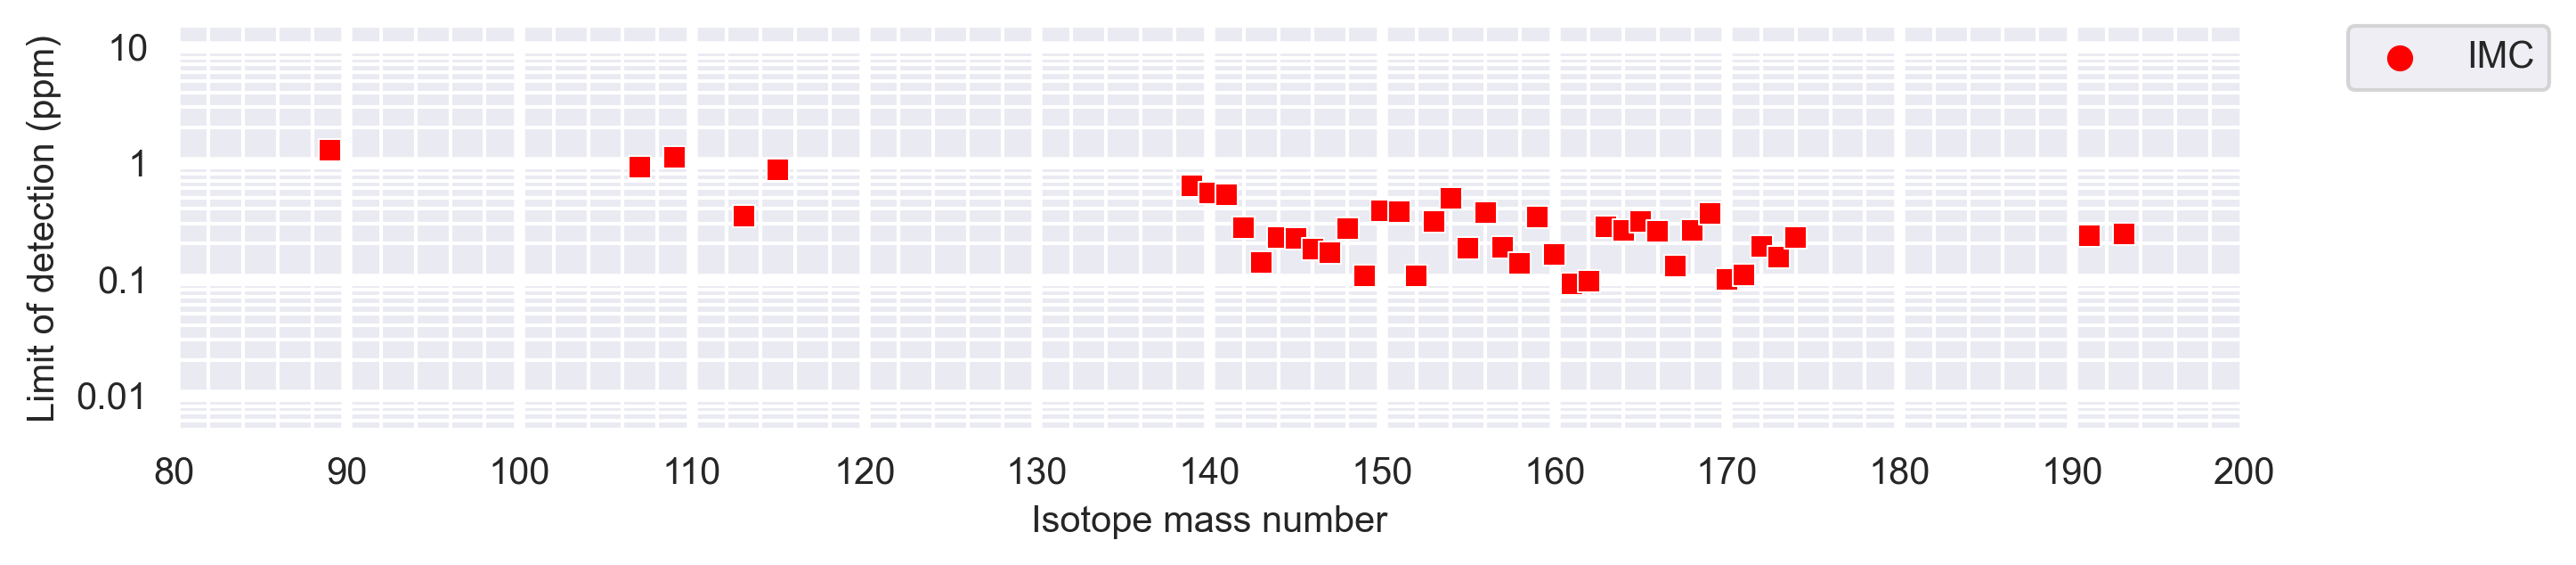

In [35]:
sns.set_style("dark")

fig, ax = plt.subplots(figsize=(10,2), dpi=300)
sns.scatterplot(
    data=df_detection_limits_select[df_detection_limits_select['step_um'] == 0.5],
    x='isotope',
    y='lob_concentration_corrected',
    #y='lob_concentration',
    ax=ax,
    color='k',
    hue='Detector',
    palette = ['red'],
    marker='s'
)

#Set log scale with plain formatting
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as ticker

ax.set(yscale="log")
ax.set_ylim([0.005,15])
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))

ax.set_xlim([80,200])
ax.set_xticks(list(range(80, 210, 10)))
ax.set_xticks(list(range(80, 200, 2)), minor=True)

#Set gridlines
ax.grid(which='major', c='w', lw=3, axis='y')
ax.grid(which='major', c='w', lw=3, axis='x')
ax.grid(which='minor', c='w', lw=1, axis='y')
ax.grid(which='minor', c='w', lw=1, axis='x')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Isotope mass number')
plt.ylabel('Limit of detection (ppm)')

savename = out_dir / 'Fig1e_IMCLimitOfDetection.svg'
print(savename)
plt.savefig(savename, bbox_inches='tight')

plt.show()


In [36]:
df_detection_limits_select

,isotope,step_um,blank_counts,blank_std,lob_intercept,lod_intercept,loq_intercept,lob_concentration,lod_concentration,loq_concentration,correction_factor,Detector,lob_concentration_corrected
9,89.0,0.5,0.272512,0.519107,1.468527,1.896642,2.849928,1.597639,2.451357,6.359364,0.802266,IMC,1.281731
10,89.0,1.0,0.247164,0.476162,1.441553,1.845097,2.756353,1.555120,2.328204,5.791280,0.802266,IMC,1.247620
11,89.0,2.0,0.194275,0.434191,1.381540,1.775000,2.672834,1.464539,2.170592,5.327246,0.802266,IMC,1.174949
24,107.0,0.5,0.020000,0.140000,1.744317,2.064679,2.968356,2.105004,2.899908,7.158898,0.431314,IMC,0.907917
25,107.0,1.0,0.027995,0.163751,1.707645,1.994210,2.777720,2.029208,2.702589,5.916353,0.431314,IMC,0.875225
...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,191.0,1.0,0.008430,0.098047,0.365778,0.502506,0.915135,0.530348,0.608052,0.918636,0.385914,IMC,0.204669
197,191.0,2.0,0.005959,0.073024,0.332382,0.439467,0.779466,0.512929,0.570905,0.802090,0.385914,IMC,0.197946
201,193.0,0.5,0.015134,0.137596,0.043775,0.214093,0.695766,0.384341,0.455706,0.737688,0.627001,IMC,0.240982
202,193.0,1.0,0.026117,0.190706,0.161305,0.370850,0.925044,0.432274,0.533045,0.927784,0.627001,IMC,0.271036


C:\Users\MerrickS\OneDrive\Work\2_UZH\Papers\1_MEZ_XRF\data\analysis\imc\5_imc_detection_limits\ExtF3b_IMCLimitOfDetectionNotCorrected.svg


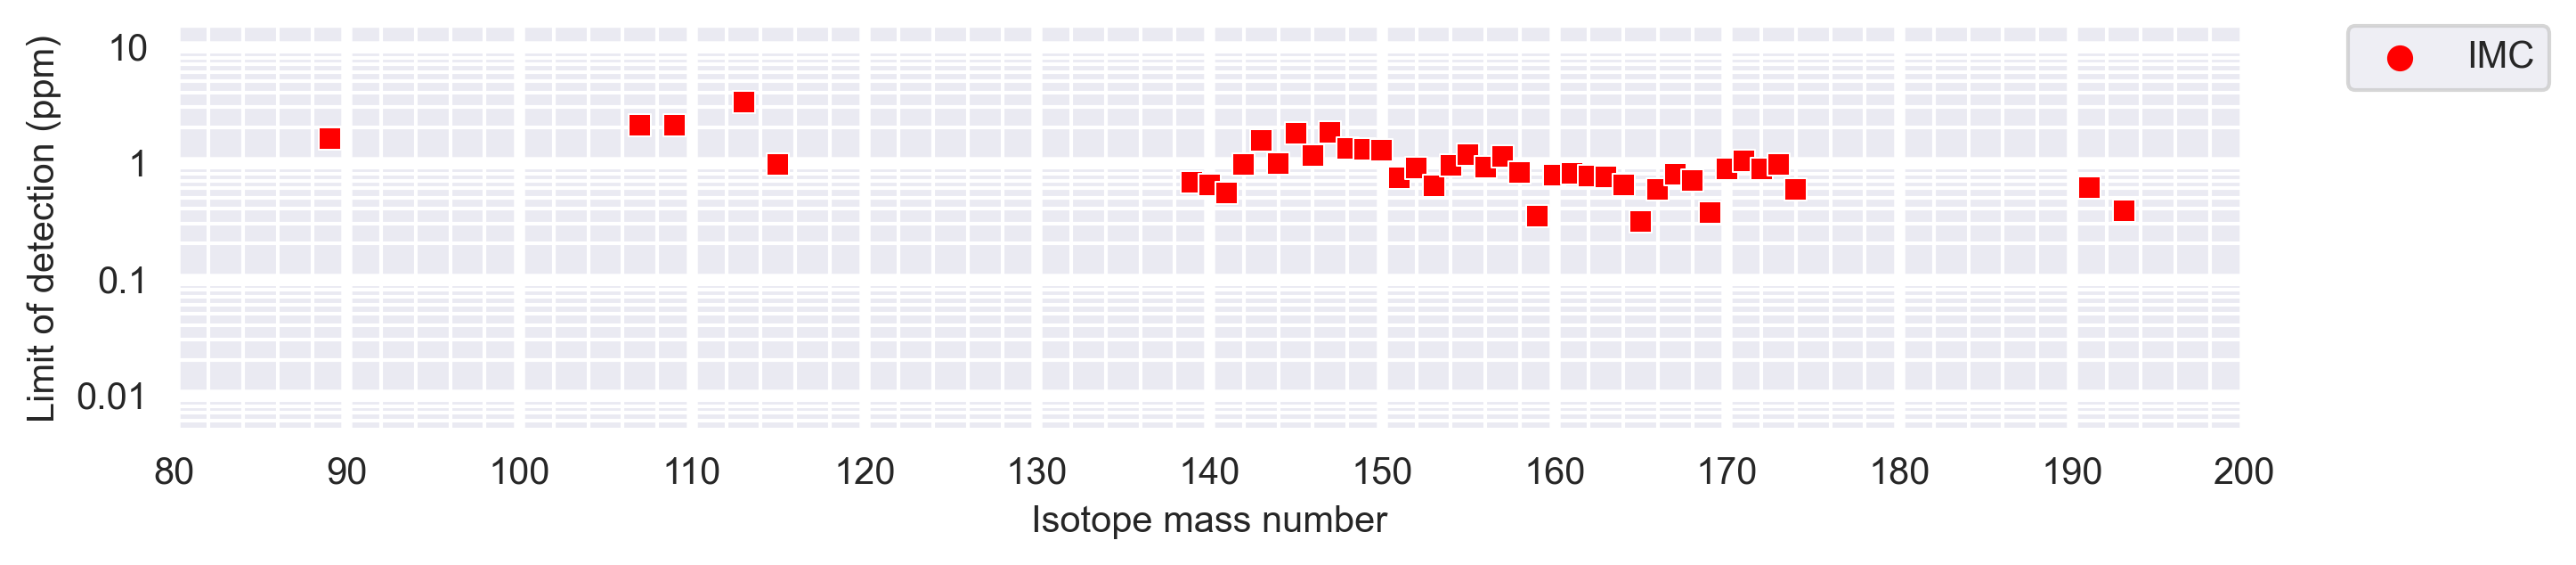

In [37]:
sns.set_style("dark")

fig, ax = plt.subplots(figsize=(10,2), dpi=300)
sns.scatterplot(
    data=df_detection_limits_select[df_detection_limits_select['step_um'] == 0.5],
    x='isotope',
    y='lob_concentration',
    ax=ax,
    color='k',
    hue='Detector',
    marker='s',
    palette = ['red'],
)

#Set log scale with plain formatting
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as ticker

ax.set(yscale="log")
ax.set_ylim([0.005,15])
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))

ax.set_xlim([80,200])
ax.set_xticks(list(range(80, 210, 10)))
ax.set_xticks(list(range(80, 200, 2)), minor=True)

#Set gridlines
ax.grid(which='major', c='w', lw=3, axis='y')
ax.grid(which='major', c='w', lw=3, axis='x')
ax.grid(which='minor', c='w', lw=1, axis='y')
ax.grid(which='minor', c='w', lw=1, axis='x')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Isotope mass number')
plt.ylabel('Limit of detection (ppm)')

savename = out_dir / 'ExtF3b_IMCLimitOfDetectionNotCorrected.svg'
print(savename)
plt.savefig(savename, bbox_inches='tight')

plt.show()
